In [39]:
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
import tqdm as tqdm
import random
import os
import json
import numpy as np

import george
from functools import partial
import scipy.optimize as op
from astropy.table import Table, vstack
from gaussian_process_example import *

In [40]:
from astropy.coordinates import Distance
import astropy.units as u
def absmag(m, z):
    '''
    Converts apparent magnitude to absolute magnitude.
    
    Args:
        m (float): apparent magnitude
        z (float): redshift
    '''
    try:
        z = float(z)
    except ValueError:
        if type(z) == str:
            z = float(z.split('±')[0])
    if m is None or m is np.nan or z is None or z is np.nan:
        return np.nan
    else:
        if z==0:
            M = m
        elif z < 0:
            M = m
        else:
            try:
                d = Distance(unit=u.pc, z=float(z), allow_negative=True)
                M = m - 5 * np.log10(d/(10*u.pc)) + 5
            except:
                M = np.nan
        return M
absmag = np.vectorize(absmag)

In [41]:
df_ztfrest = pd.read_csv('ZTFReST.csv')
ztfredshifts = df_ztfrest.dropna(subset=["redshift"]).copy().reset_index(drop=True)
df_eval = pd.read_csv('candidateEval12-09-24.csv')
# df_eval['redshift'] = df_eval['redshift'].apply(lambda x: float(x.split('±')[0]) if '±' in x else float(x))
# df_eval.to_csv('candidateEval07-18.csv', index=False)
# df_eval = df_eval.dropna(subset=["redshift"]).copy().reset_index(drop=True)

objIds = sorted(list(set(df_eval["object"])))

In [42]:
for i, row in enumerate(df_eval.itertuples()):
    z = row.redshift
    if z is None or z is np.nan:
        continue
    elif type(z) == str:
        z = float(z.split('±')[0])
    df_eval.at[i, 'redshift'] = z
        

In [43]:
#df_eval.to_csv('candidateEval07-18.csv', index=False)

In [44]:
data_folder = 'data/'
photometry_dict = {}


for root, dirs, files in sorted(os.walk(data_folder)):
    for file in files:
        if file == 'photometry.json':
            folder_name = os.path.basename(root)
            file_path = os.path.join(root, file)
            with open(file_path, 'r') as f:
                photometry_dict[folder_name] = json.load(f)

lc_dict = {key: pd.DataFrame.from_dict(val) for key, val in photometry_dict.items()}
## remove empty lightcurves
lc_dict = {key: val for key, val in lc_dict.items() if not val.empty}

In [45]:
fig, ax = plt.subplots()
ax.scatter(lc_dict['ZTF24abvevzs'].mjd, lc_dict['ZTF24abvevzs'].mag*lc_dict['ZTF24abvevzs'].magerr)

Compile all the objects into one dataframe, with the following columns:
- `id`: the object id
- `class`: the object class
- `redshift`: the redshift of the object
- `mjd`: time of observation
- `mag`: the magnitude of the object
- `mag_err`: the error of the magnitude
- `filter`: the filter of the observation

In [46]:
df_objects = pd.DataFrame(columns=['obj_id', 'type', 'redshift', 'mjd', 'mag', 'magerr', 'filter', 'snr'])

for obj_id in objIds:
    df_lc = lc_dict[obj_id]
    df_lc.dropna(subset=['mag', 'magerr'], inplace=True)
    df_lc['id'] = obj_id
    df_lc = df_lc[['obj_id', 'mjd', 'mag', 'magerr', 'filter', 'snr']]
    df_lc['type'] = df_eval.loc[df_eval['object'] == obj_id, 'class'].values[0]
    df_lc['redshift'] = df_eval.loc[df_eval['object'] == obj_id, 'redshift'].values[0]
    df_objects = pd.concat([df_objects, df_lc])

/tmp/ipykernel_117061/982688885.py:8: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  df_lc['type'] = df_eval.loc[df_eval['object'] == obj_id, 'class'].values[0]
/tmp/ipykernel_117061/982688885.py:9: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  df_lc['redshift'] = df_eval.loc[df_eval['object'] == obj_id, 'redshift'].values[0]
/tmp/ipykernel_117061/982688885.py:8: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

In [47]:
df_objects = df_objects[(df_objects['filter'] == 'ztfr') | (df_objects['filter'] == 'ztfg') | (df_objects['filter'] == 'ztfi')]
df_objects = df_objects[df_objects['snr']>5]

In [48]:
df_objects_norm = pd.DataFrame()
df_objects_norm['obj_id'] = df_objects['obj_id']
df_objects_norm['type'] = df_objects['type']
df_objects_norm['redshift'] = df_objects['redshift']
df_objects_norm['mjd'] = df_objects['mjd']
df_objects_norm['mag'] = df_objects['mag']
df_objects_norm['magerr'] = df_objects['magerr']
df_objects_norm['filter'] = df_objects['filter']
df_objects_norm['mjd_0'] = df_objects.groupby('obj_id')['mjd'].transform(lambda x: np.min(x))
df_objects_norm['t'] = df_objects.groupby('obj_id')['mjd'].transform(lambda x: x - np.min(x))
df_objects_norm['absmag'] = absmag(df_objects['mag'], df_objects['redshift'])
display(df_objects_norm)
# df_objects_norm.to_csv('gp_objects_original_observations.csv', index=False)

obj_id type  redshift           mjd        mag    magerr filter  \
23  ZTF18aakuewf  Ibn    0.0636  58226.340532  18.961000  0.031726   ztfr   
24  ZTF18aakuewf  Ibn    0.0636  58226.358623  18.871901  0.029414   ztfr   
26  ZTF18aakuewf  Ibn    0.0636  58226.378947  18.922800  0.033493   ztfr   
28  ZTF18aakuewf  Ibn    0.0636  58226.414456  18.856501  0.031619   ztfr   
30  ZTF18aakuewf  Ibn    0.0636  58226.415394  18.849501  0.033379   ztfr   
..           ...  ...       ...           ...        ...       ...    ...   
87  ZTF24abvevzs  IIb    0.0350  60650.533484  19.486008  0.068334   ztfg   
90  ZTF24abvevzs  IIb    0.0350  60652.490127  20.068013  0.170292   ztfg   
91  ZTF24abvevzs  IIb    0.0350  60652.490127  20.068001  0.170292   ztfg   
92  ZTF24abvevzs  IIb    0.0350  60652.491644  20.109029  0.140443   ztfg   
94  ZTF24abvevzs  IIb    0.0350  60652.538137  19.863190  0.129076   ztfr   

           mjd_0         t     absmag  
23  58226.340532  0.000000 -13.389765  
24  58226.340532  0.018090 -13.478865  
26  58226.340532  0.038414 -13.427966  
28  58226.340532  0.073924 -13.494265  
30  58226.340532  0.074861 -13.501265  
..           ...       ...        ...  
87  60646.432303  4.101181 -11.523548  
90  60646.432303  6.057824 -10.941543  
91  60646.432303  6.057824 -10.941555  
92  60646.432303  6.059340 -10.900527  
94  60646.432303  6.105833 -11.146366  

[9398 rows x 10 columns]

In [52]:
df_objects_matched = pd.DataFrame(columns=['obj_id', 'type', 'redshift', 'mjd', 'mjd_0', 't', 'mag_ztfg',
    'abs_mag_ztfg', 'mag_error_ztfg', 'mag_ztfr', 'abs_mag_ztfr',
    'mag_error_ztfr', 'mag_ztfi', 'abs_mag_ztfi', 'mag_error_ztfi',])

for row in df_objects_norm.itertuples():
    obj_id = row.obj_id
    mjd = row.mjd
    t = row.t
    mag = row.mag
    magerr = row.magerr
    filter = row.filter
    absmag = row.absmag
    abs_label = 'abs_mag_' + filter
    mag_label = 'mag_' + filter
    magerr_label = 'mag_error_' + filter
    
    df_objects_matched = pd.concat([df_objects_matched, pd.DataFrame([{'obj_id': obj_id, 'type': row.type, 'redshift': row.redshift, 'mjd': mjd, 'mjd_0': row.mjd_0, 't': t, mag_label: mag, abs_label: absmag, magerr_label: magerr}])], ignore_index=True)
display(df_objects_matched)

# df_objects_matched.to_csv('gp_objects_original_observations(matched).csv', index=False)

obj_id type  redshift           mjd         mjd_0         t  \
0     ZTF18aakuewf  Ibn    0.0636  58226.340532  58226.340532  0.000000   
1     ZTF18aakuewf  Ibn    0.0636  58226.358623  58226.340532  0.018090   
2     ZTF18aakuewf  Ibn    0.0636  58226.378947  58226.340532  0.038414   
3     ZTF18aakuewf  Ibn    0.0636  58226.414456  58226.340532  0.073924   
4     ZTF18aakuewf  Ibn    0.0636  58226.415394  58226.340532  0.074861   
...            ...  ...       ...           ...           ...       ...   
9393  ZTF24abvevzs  IIb    0.0350  60650.533484  60646.432303  4.101181   
9394  ZTF24abvevzs  IIb    0.0350  60652.490127  60646.432303  6.057824   
9395  ZTF24abvevzs  IIb    0.0350  60652.490127  60646.432303  6.057824   
9396  ZTF24abvevzs  IIb    0.0350  60652.491644  60646.432303  6.059340   
9397  ZTF24abvevzs  IIb    0.0350  60652.538137  60646.432303  6.105833   

       mag_ztfg  abs_mag_ztfg  mag_error_ztfg   mag_ztfr  abs_mag_ztfr  \
0           NaN           NaN             NaN  18.961000    -13.389765   
1           NaN           NaN             NaN  18.871901    -13.478865   
2           NaN           NaN             NaN  18.922800    -13.427966   
3           NaN           NaN             NaN  18.856501    -13.494265   
4           NaN           NaN             NaN  18.849501    -13.501265   
...         ...           ...             ...        ...           ...   
9393  19.486008    -11.523548        0.068334        NaN           NaN   
9394  20.068013    -10.941543        0.170292        NaN           NaN   
9395  20.068001    -10.941555        0.170292        NaN           NaN   
9396  20.109029    -10.900527        0.140443        NaN           NaN   
9397        NaN           NaN             NaN  19.863190    -11.146366   

      mag_error_ztfr  mag_ztfi  abs_mag_ztfi  mag_error_ztfi  
0           0.031726       NaN           NaN             NaN  
1           0.029414       NaN           NaN             NaN  
2           0.033493       NaN           NaN             NaN  
3           0.031619       NaN           NaN             NaN  
4           0.033379       NaN           NaN             NaN  
...              ...       ...           ...             ...  
9393             NaN       NaN           NaN             NaN  
9394             NaN       NaN           NaN             NaN  
9395             NaN       NaN           NaN             NaN  
9396             NaN       NaN           NaN             NaN  
9397        0.129076       NaN           NaN             NaN  

[9398 rows x 15 columns]

In [19]:
df_objects[df_objects['magerr'] < 0]

Empty DataFrame
Columns: [obj_id, type, redshift, mjd, mag, magerr, filter, snr]
Index: []

In [20]:
def Mag2Flux(df):
    df_copy = df.dropna().copy()
    df_copy['flux'] = 10 ** (-0.4 * (df_copy['mag'] - 23.9))
    df_copy['flux_error'] = (df_copy['magerr'] / (2.5 / np.log(10))) * df_copy['flux']

    df_copy = df_copy[['obj_id', 'mjd', 'flux', 'flux_error', 'filter', 'type', 'redshift']]
    return df_copy

def Normalize(df):
    df_copy = df.dropna().copy()
    df_copy['mjd_0'] = df_copy.groupby('obj_id')['mjd'].transform(lambda x: np.min(x))
    df_copy['mjd'] = df_copy.groupby('obj_id')['mjd'].transform(lambda x: x - np.min(x))

    df_copy.reset_index(drop=True, inplace=True)
    return df_copy


In [21]:
flux_df = Mag2Flux(df_objects)
flux_df = flux_df.dropna(subset=['flux', 'flux_error']).copy()
norm_df = Normalize(flux_df)


In [22]:
flux_df['obj_id'].unique()

array(['ZTF18aakuewf', 'ZTF18aalrxas', 'ZTF18abffyqp', 'ZTF18abvkmgw',
       'ZTF18abwkrbl', 'ZTF19aanbpus', 'ZTF19aapfmki', 'ZTF19aatesgp',
       'ZTF19abacxod', 'ZTF19abxjrge', 'ZTF19abxtcio', 'ZTF19abyjzvd',
       'ZTF19acbumks', 'ZTF19accjfgv', 'ZTF20aahfqpm', 'ZTF20aajnksq',
       'ZTF20aaxhzhc', 'ZTF20aayrobw', 'ZTF20aazchcq', 'ZTF20abstsxb',
       'ZTF20aburywx', 'ZTF20abwysqy', 'ZTF20abwzqzo', 'ZTF20acgigfo',
       'ZTF20acgiglu', 'ZTF20acigusw', 'ZTF20aclfmwn', 'ZTF20acozryr',
       'ZTF20acqntkr', 'ZTF20actqnhg', 'ZTF21aaabrpu', 'ZTF21aaabwfu',
       'ZTF21aabxjqr', 'ZTF21aagwbjr', 'ZTF21aapkbav', 'ZTF21aaqzrat',
       'ZTF21abbvvmf', 'ZTF21abexegc', 'ZTF21abfmpwn', 'ZTF21abhywxv',
       'ZTF21aciosfu', 'ZTF22aaajecp', 'ZTF22aabjpxh', 'ZTF22aahgvlx',
       'ZTF22aaibbvy', 'ZTF22aajrrzz', 'ZTF22aayluxo', 'ZTF22aazmooy',
       'ZTF22abfjnpj', 'ZTF22abfxmpc', 'ZTF22abijszk', 'ZTF22abmsaxp',
       'ZTF22abntkbk', 'ZTF22abuzpzz', 'ZTF22acaruqr', 'ZTF23aadhssd',
      

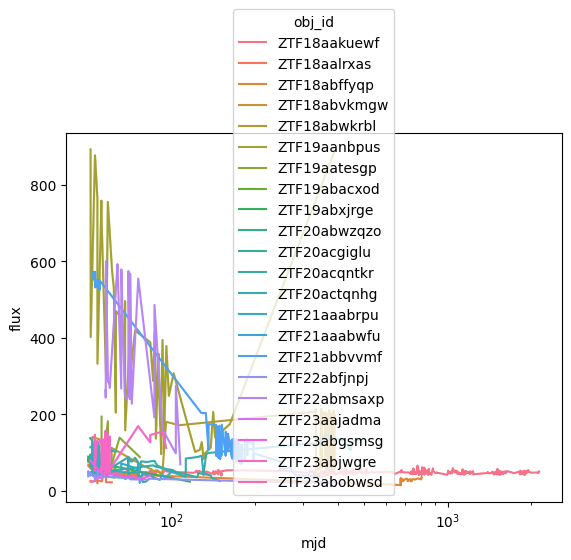

In [23]:
fig, ax = plt.subplots()
sns.lineplot(data=norm_df[norm_df['mjd']>50], x='mjd', y='flux', hue='obj_id', ax=ax)
ax.set_xscale('log')

In [28]:
long_objects = norm_df[norm_df.groupby('obj_id')['mjd'].transform('max') > 50]['obj_id'].unique()

# fig, ax = plt.subplots()
# sns.lineplot(data=norm_df[norm_df['obj_id'].isin(long_objects)][norm_df['mjd']<50][norm_df['obj_id']!='ZTF22abfjnpj'], x='mjd', y='flux', hue='obj_id', ax=ax)

In [25]:
def count_obj_by_type(df):
    obj_id_count_per_type = df.groupby('type')['obj_id'].nunique()
    print(obj_id_count_per_type)

In [26]:
from sklearn.model_selection import GroupShuffleSplit

gss = GroupShuffleSplit(n_splits=1, test_size=0.2, random_state=42)

train_idx, test_idx = next(gss.split(norm_df, groups=norm_df['obj_id']))

train_data = norm_df.iloc[train_idx]
test_data = norm_df.iloc[test_idx]

In [27]:
count_obj_by_type(train_data)
count_obj_by_type(test_data)

type
Cataclysmic                9
FBOT                       2
GRB                        1
II                         7
IIP                        1
IIb                       14
Ia                         3
Ib                         3
Ib/c;Ib-pec                1
Ibn                        2
Novae                      3
Novae;Classical Nova       4
Tidal Disruption Event     1
U Gem                      1
afterglow                  2
afterglow; Ic-BL           1
long GRB                   4
Name: obj_id, dtype: int64
type
Cataclysmic         1
II                  1
IIb                 7
Ia                  2
Ibn                 1
Ic-BL               1
Novae               1
afterglow; Ic-BL    1
Name: obj_id, dtype: int64


In [29]:
pb_wavelengths = {
    'ztfg': 4800.,
    'ztfr': 6400.,
    'ztfi': 7900.,
} 
## Note for future reference: http://svo2.cab.inta-csic.es/theory/fps/index.php?id=Palomar/ZTF.g

filters = ['ztfg', 'ztfr', 'ztfi']

gp_wavelengths = np.vectorize(pb_wavelengths.get)(filters)

inverse_gp_wavelengths = {v: k for k, v in pb_wavelengths.items()}

# These functions are taken from the 'Paying Attention to Astronomical Transients' paper

def fit_2d_gp(obj_data, kernel=None, return_kernel=False, global_fit=False, **kwargs):
    if kernel is None:
        guess_length_scale = 20.0
        signal_to_noises = np.abs(obj_data.flux) / np.sqrt(
            obj_data.flux_error ** 2 + (1e-2 * np.max(obj_data.flux)) ** 2
        )
        scale = np.abs(obj_data.flux[signal_to_noises.idxmax()])
        kernel = (0.5 * scale) ** 2 * george.kernels.Matern32Kernel([
            guess_length_scale ** 2, 6000 ** 2], ndim=2)
        kernel.freeze_parameter("k2:metric:log_M_1_1")


    obj_times = obj_data.mjd.astype(float)
    obj_flux = obj_data.flux.astype(float)
    obj_flux_error = obj_data.flux_error.astype(float)
    obj_wavelengths = obj_data['filter'].map(pb_wavelengths)

    def neg_log_like(p):  # Objective function: negative log-likelihood
        gp.set_parameter_vector(p)
        loglike = gp.log_likelihood(obj_flux, quiet=True)
        return -loglike if np.isfinite(loglike) else 1e25

    def grad_neg_log_like(p):  # Gradient of the objective function.
        gp.set_parameter_vector(p)
        return -gp.grad_log_likelihood(obj_flux, quiet=True)

    gp = george.GP(kernel)
    default_gp_param = gp.get_parameter_vector()
    x_data = np.vstack([obj_times, obj_wavelengths]).T
    gp.compute(x_data, obj_flux_error)

    bounds = [(0, np.log(1000 ** 2))]
    bounds = [(default_gp_param[0] - 10, default_gp_param[0] + 10)] + bounds
    results = op.minimize(neg_log_like, gp.get_parameter_vector(),
                          jac=grad_neg_log_like, method="L-BFGS-B",
                          bounds=bounds, tol=1e-6)

    if results.success:
        gp.set_parameter_vector(results.x)
    else:
        # Fit failed. Print out a warning, and use the initial guesses for fit
        # parameters.
        obj = obj_data['obj_id'][0]
        print("GP fit failed for {}! Using guessed GP parameters.".format(obj))
        gp.set_parameter_vector(default_gp_param)

    gp_predict = partial(gp.predict, obj_flux)

    if return_kernel:
        return kernel, gp_predict
    else:
        return gp_predict


def predict_2d_gp(gp_predict, gp_times, gp_wavelengths):
    """Outputs the predictions of a Gaussian Process.

    Parameters
    ----------
    gp_predict : functools.partial of george.gp.GP
        The GP instance that was used to fit the object.
    gp_times : numpy.ndarray
        Times to evaluate the Gaussian Process at.
    gp_wavelengths : numpy.ndarray
        Wavelengths to evaluate the Gaussian Process at.

    Returns
    -------
    obj_gps : pandas.core.frame.DataFrame, optional
        Time, flux and flux error of the fitted Gaussian Process.
    """
    unique_wavelengths = np.unique(gp_wavelengths)
    number_gp = len(gp_times)
    obj_gps = []
    for wavelength in unique_wavelengths:
        gp_wavelengths = np.ones(number_gp) * wavelength
        pred_x_data = np.vstack([gp_times, gp_wavelengths]).T
        pb_pred, pb_pred_var = gp_predict(pred_x_data, return_var=True)
        # stack the GP results in a array momentarily
        obj_gp_pb_array = np.column_stack((gp_times, pb_pred, np.sqrt(pb_pred_var)))
        obj_gp_pb = Table(
            [
                obj_gp_pb_array[:, 0],
                obj_gp_pb_array[:, 1],
                obj_gp_pb_array[:, 2],
                [wavelength] * number_gp,
            ],
            names=["mjd", "flux", "flux_error", "filter"],
        )
        if len(obj_gps) == 0:  # initialize the table for 1st passband
            obj_gps = obj_gp_pb
        else:  # add more entries to the table
            obj_gps = vstack((obj_gps, obj_gp_pb))
            
    obj_gps = obj_gps.to_pandas()
    return obj_gps

def process_gaussian(df, kernel=None, number_gp=100, save=False, name=''):
    
    res_df = pd.DataFrame()

    for obj_id in tqdm.tqdm(df['obj_id'].unique()):
        obj_df = df[df['obj_id'] == obj_id]
        type_obj = obj_df['type'].values[0]
        mjd_0 = obj_df['mjd_0'].values[0]
        redshift = obj_df['redshift'].values[0]
        obj_df.reset_index(drop=True, inplace=True)

        available_filters = obj_df['filter'].unique()
        gp_wavelengths = np.vectorize(pb_wavelengths.get)(available_filters)
        inverse_gp_wavelengths = {v: k for k, v in pb_wavelengths.items() if k in available_filters}
        gp_predict = fit_2d_gp(obj_df, kernel=kernel)
        gp_times = np.linspace(min(obj_df['mjd']), max(obj_df['mjd']), number_gp)

        obj_gps = predict_2d_gp(gp_predict, gp_times, gp_wavelengths)
        obj_gps['filter'] = obj_gps['filter'].map(inverse_gp_wavelengths)

        obj_gps = obj_gps.pivot_table(index=['mjd'], columns='filter', values=['flux', 'flux_error'])
        obj_gps = obj_gps.reset_index()
        obj_gps.columns = [col[0] if col[0] == 'mjd' else '_'.join(col).strip() for col in obj_gps.columns.values]
        obj_gps['type'] = type_obj
        obj_gps['obj_id'] = obj_id
        obj_gps['mjd_0'] = mjd_0
        obj_gps['redshift'] = redshift

        res_df = pd.concat([res_df, obj_gps])

    res_df.reset_index(drop=True, inplace=True)

    if save:
        #types_str = '_'.join(df['type'].unique()) if hasattr(df['type'].unique(), '__iter__') else str(df['type'].unique())
        #filename = f'{name}_gp_{types_str}.csv'
        num_types_str = str(len(df['type'].unique()))
        filename = f'{name}_gp_n{num_types_str}.csv'
        filename = filename.replace(' ', '_')
        res_df.to_csv(filename, index=False)
        print(f'File {filename} saved successfully')
    return res_df

def save_kernel(kernel, filename):
    with open(filename, 'wb') as f:
        pickle.dump(kernel, f)
    print(f'Kernel saved to {filename}')

def load_kernel(filename):
    with open(filename, 'rb') as f:
        kernel = pickle.load(f)
    print(f'Kernel loaded from {filename}')
    return kernel

In [30]:
kernel = load_kernel('kernel.pkl')

Kernel loaded from kernel.pkl


In [31]:
# test_results = process_gaussian(test_data, kernel=kernel, save=True, name='test')
# train_results = process_gaussian(train_data, kernel=kernel, save=True, name='train')
total_results = process_gaussian(norm_df[norm_df['mjd']<50], kernel=kernel, save=False, name='total', number_gp=1000)

100%|██████████| 74/74 [00:21<00:00,  3.38it/s]


In [32]:
total_results[total_results['obj_id'] == 'ZTF24abvevzs']

mjd  flux_ztfg  flux_ztfr  flux_error_ztfg  flux_error_ztfr type  \
72001  0.000000  36.331010  25.066002         2.034971         3.157210  IIb   
72002  0.006112  36.878915  25.505385         1.897780         2.788540  IIb   
72003  0.012224  37.431393  25.949203         1.804559         2.448082  IIb   
72004  0.018336  37.987503  26.397472         1.755290         2.151762  IIb   
72005  0.024448  38.546301  26.850209         1.748509         1.923001  IIb   
...         ...        ...        ...              ...              ...  ...   
72996  6.081386  33.493383  40.961798         3.488673         5.252959  IIb   
72997  6.087498  33.463261  40.930338         3.842217         5.054402  IIb   
72998  6.093610  33.432509  40.895906         4.235472         4.909244  IIb   
72999  6.099721  33.401076  40.858402         4.657035         4.823773  IIb   
73000  6.105833  33.368917  40.817727         5.098662         4.802653  IIb   

             obj_id         mjd_0  redshift  flux_ztfi  flux_error_ztfi  
72001  ZTF24abvevzs  60646.432303     0.035        NaN              NaN  
72002  ZTF24abvevzs  60646.432303     0.035        NaN              NaN  
72003  ZTF24abvevzs  60646.432303     0.035        NaN              NaN  
72004  ZTF24abvevzs  60646.432303     0.035        NaN              NaN  
72005  ZTF24abvevzs  60646.432303     0.035        NaN              NaN  
...             ...           ...       ...        ...              ...  
72996  ZTF24abvevzs  60646.432303     0.035        NaN              NaN  
72997  ZTF24abvevzs  60646.432303     0.035        NaN              NaN  
72998  ZTF24abvevzs  60646.432303     0.035        NaN              NaN  
72999  ZTF24abvevzs  60646.432303     0.035        NaN              NaN  
73000  ZTF24abvevzs  60646.432303     0.035        NaN              NaN  

[1000 rows x 11 columns]

In [33]:
color_dict = {'ztfg': 'green', 'ztfr': 'red', 'ztfi': 'yellow'}
def plot_gp(obj_model, number_col=4, show_title=True, show_legend=True):
    color_dict = {'ztfg': 'green', 'ztfr': 'red', 'ztfi': 'yellow'}
    f, ax = plt.subplots(figsize=(10, 6))
    ax.set_xlabel('Time (mjd)')
    ax.set_ylabel('Flux') 
    if show_title:
        obj_id = obj_model['obj_id'].iloc[0]
        ax.set_title(f'{obj_id} | Type: {obj_model["type"].iloc[0]}')
    if show_legend:
        ax.legend(ncol=number_col)

    # Plotting model data if available
    if obj_model is not None:
        # Iterate over the filters present in the obj_model DataFrame
        for column in obj_model.columns:
            if 'flux' in column and column != 'mjd':
                filter_name = column.split('_')[1]
                if filter_name in color_dict:
                    if not all(obj_model[column] == -1):
                        ax.plot(obj_model['mjd'], obj_model[column], label=f'Model {filter_name}', color=color_dict[filter_name])
    
                        # Plot error band if error data is available
                        error_column = f'flux_error_{filter_name}'
                        if error_column in obj_model.columns:
                            model_flux_error = obj_model[error_column]
                            ax.fill_between(obj_model['mjd'], obj_model[column]-model_flux_error, obj_model[column]+model_flux_error, color=color_dict[filter_name], alpha=0.20)

    return f,ax

In [34]:
total_results

mjd   flux_ztfg   flux_ztfr  flux_error_ztfg  flux_error_ztfr  \
0      0.000000  142.373588   98.668109        30.843697         1.246373   
1      0.049981  145.014457  101.582057        30.013242         1.080243   
2      0.099961  147.656847  104.490322        29.187955         1.080575   
3      0.149942  150.300692  107.379974        28.367979         1.219787   
4      0.199923  152.945927  110.245034        27.553467         1.433721   
...         ...         ...         ...              ...              ...   
72996  6.081386   33.493383   40.961798         3.488673         5.252959   
72997  6.087498   33.463261   40.930338         3.842217         5.054402   
72998  6.093610   33.432509   40.895906         4.235472         4.909244   
72999  6.099721   33.401076   40.858402         4.657035         4.823773   
73000  6.105833   33.368917   40.817727         5.098662         4.802653   

      type        obj_id         mjd_0  redshift  flux_ztfi  flux_error_ztfi  
0      Ibn  ZTF18aakuewf  58226.340532    0.0636        NaN              NaN  
1      Ibn  ZTF18aakuewf  58226.340532    0.0636        NaN              NaN  
2      Ibn  ZTF18aakuewf  58226.340532    0.0636        NaN              NaN  
3      Ibn  ZTF18aakuewf  58226.340532    0.0636        NaN              NaN  
4      Ibn  ZTF18aakuewf  58226.340532    0.0636        NaN              NaN  
...    ...           ...           ...       ...        ...              ...  
72996  IIb  ZTF24abvevzs  60646.432303    0.0350        NaN              NaN  
72997  IIb  ZTF24abvevzs  60646.432303    0.0350        NaN              NaN  
72998  IIb  ZTF24abvevzs  60646.432303    0.0350        NaN              NaN  
72999  IIb  ZTF24abvevzs  60646.432303    0.0350        NaN              NaN  
73000  IIb  ZTF24abvevzs  60646.432303    0.0350        NaN              NaN  

[73001 rows x 11 columns]

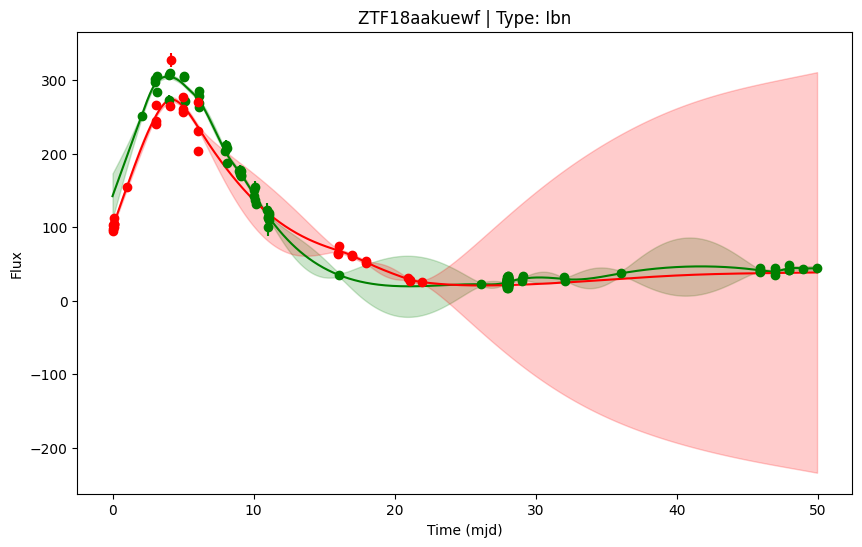

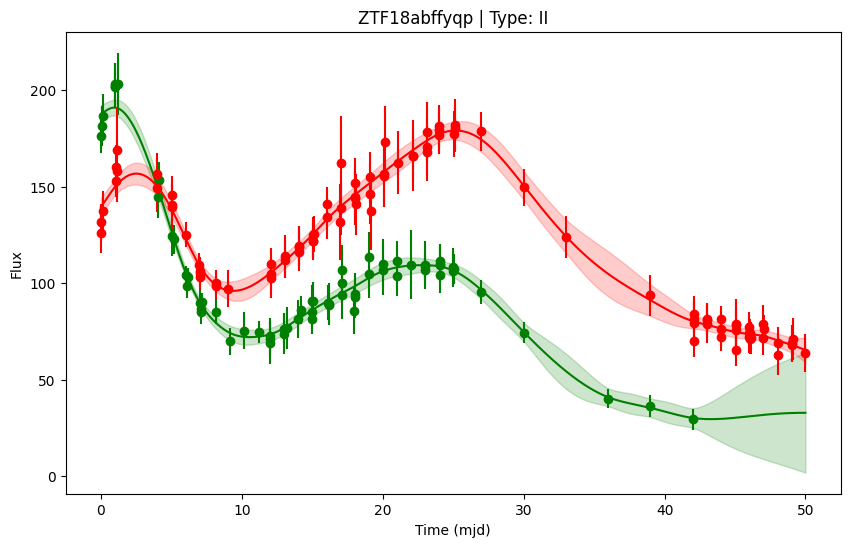

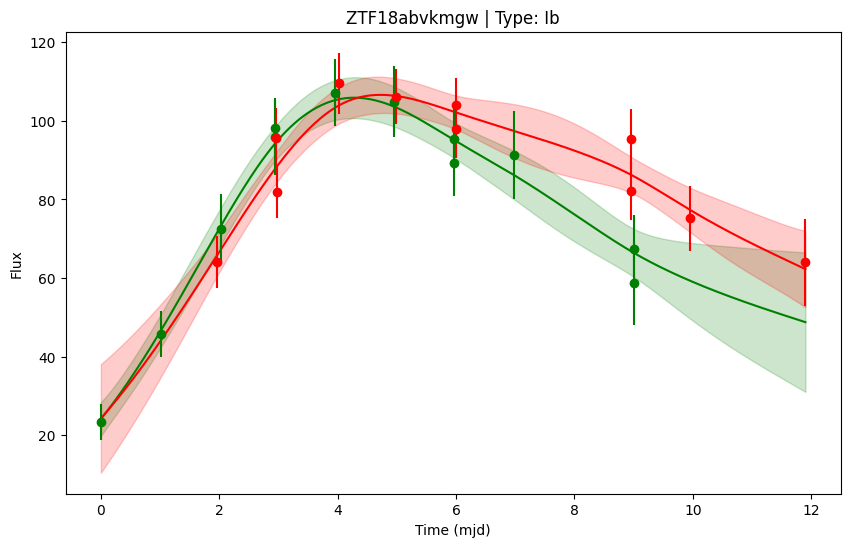

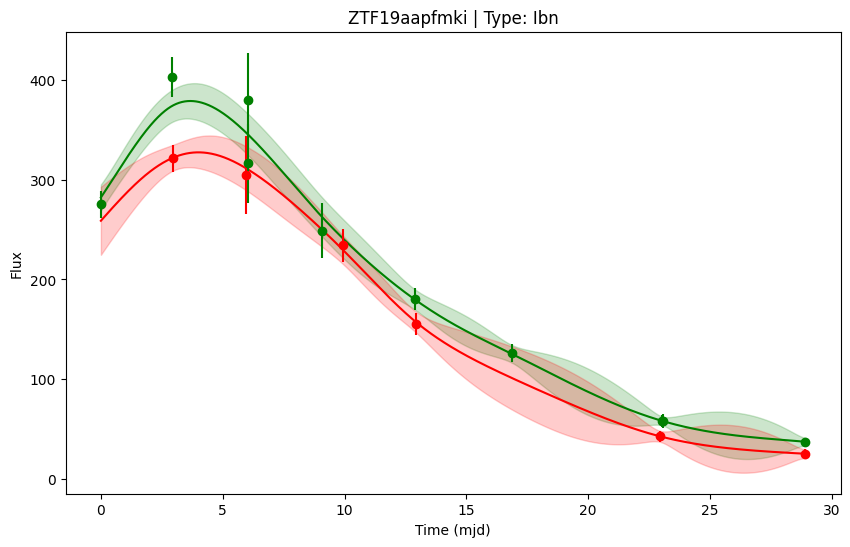

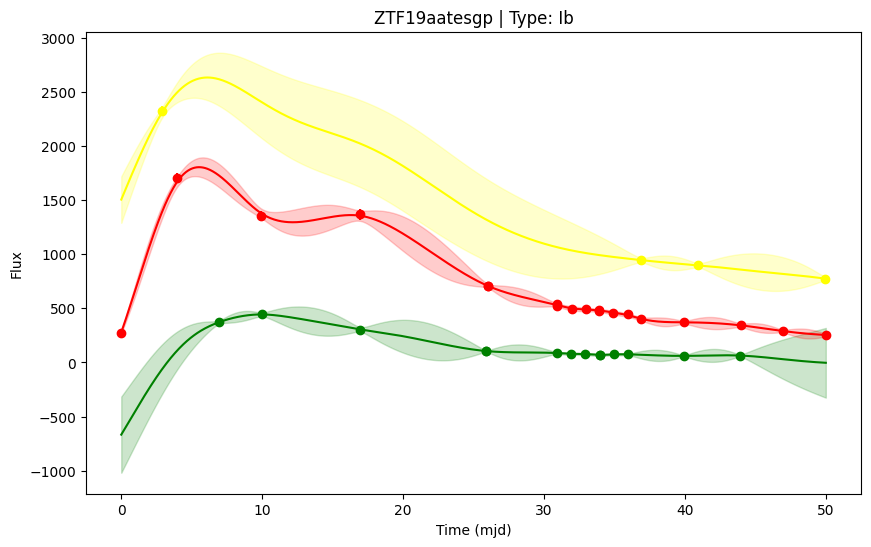

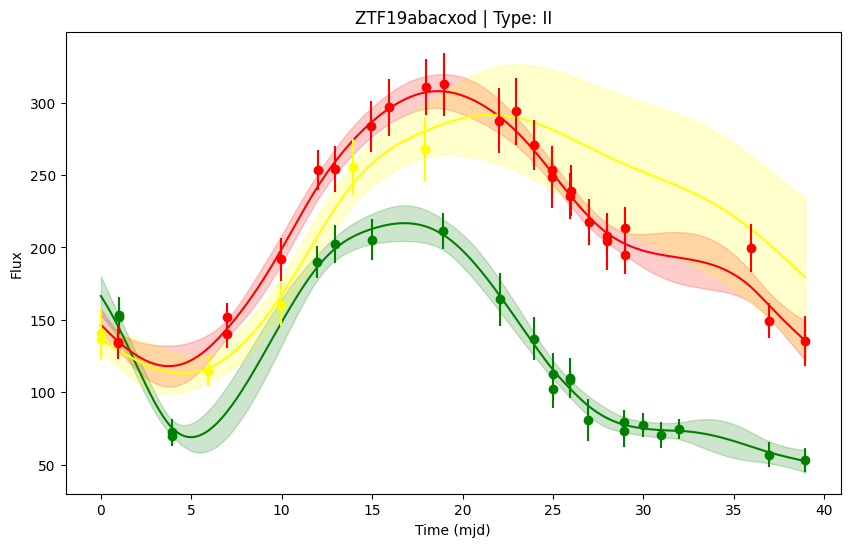

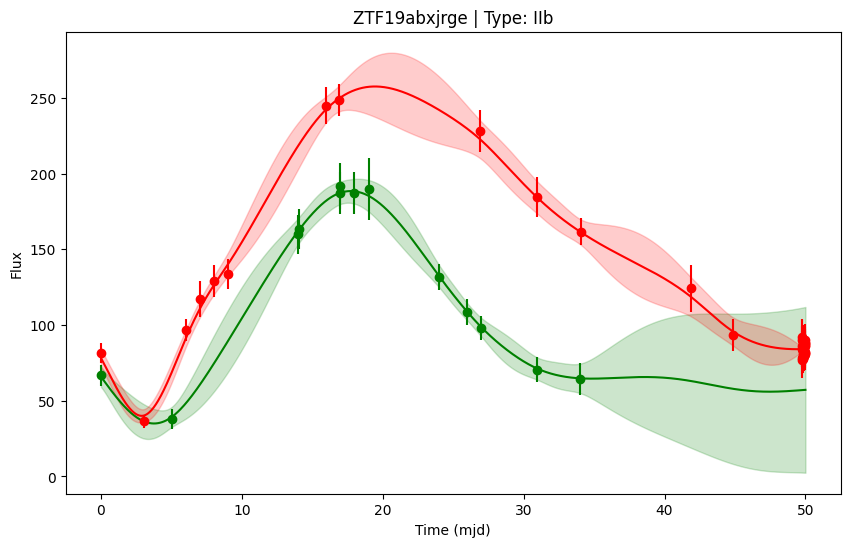

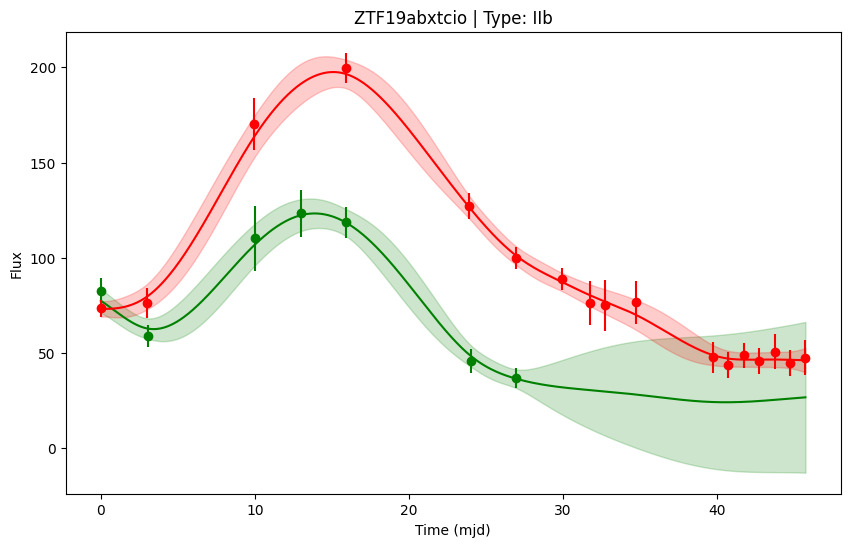

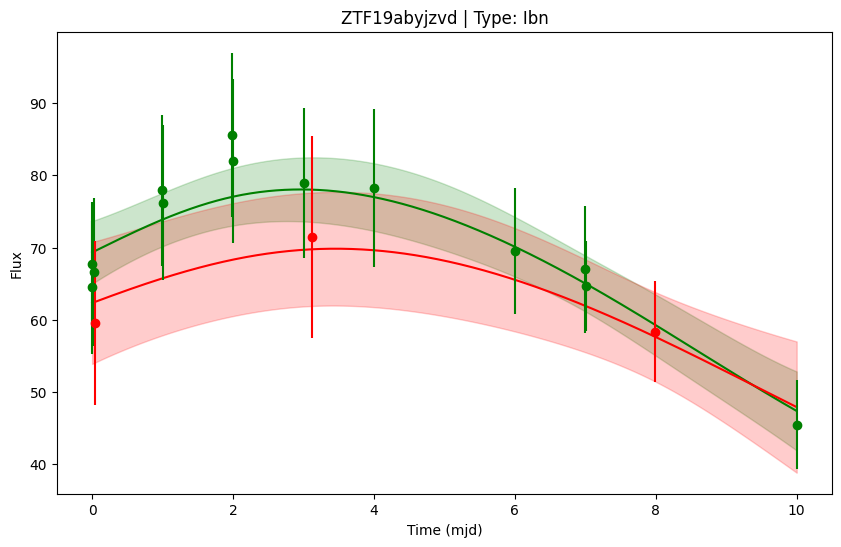

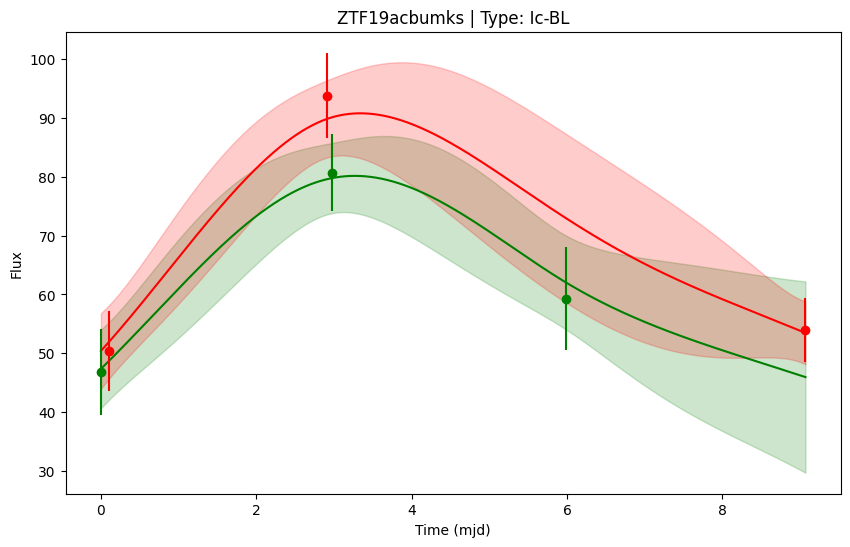

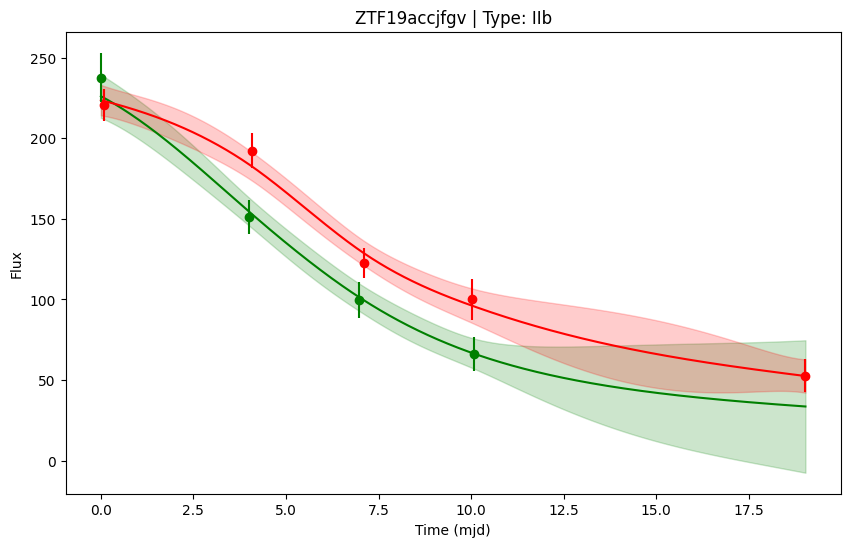

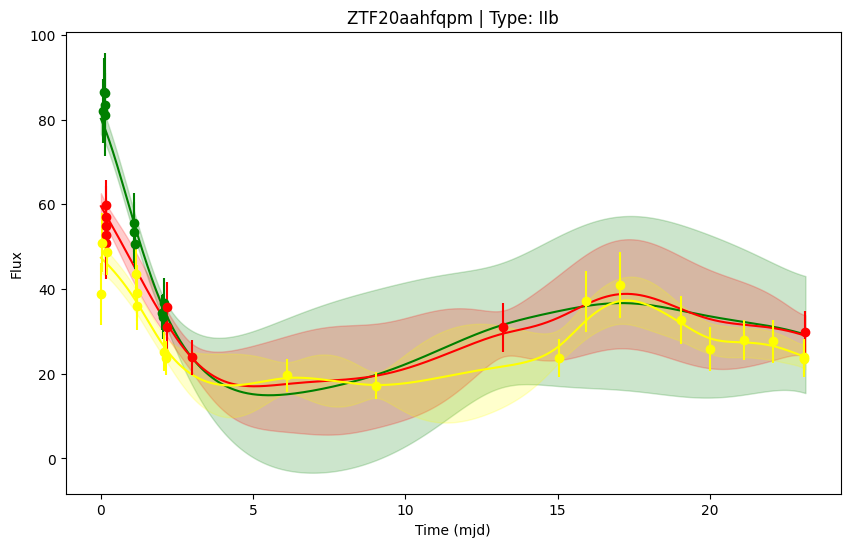

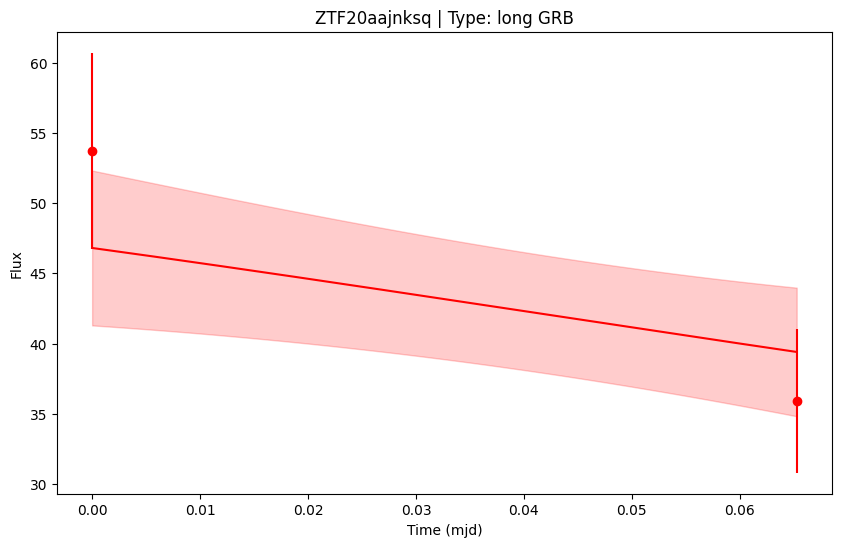

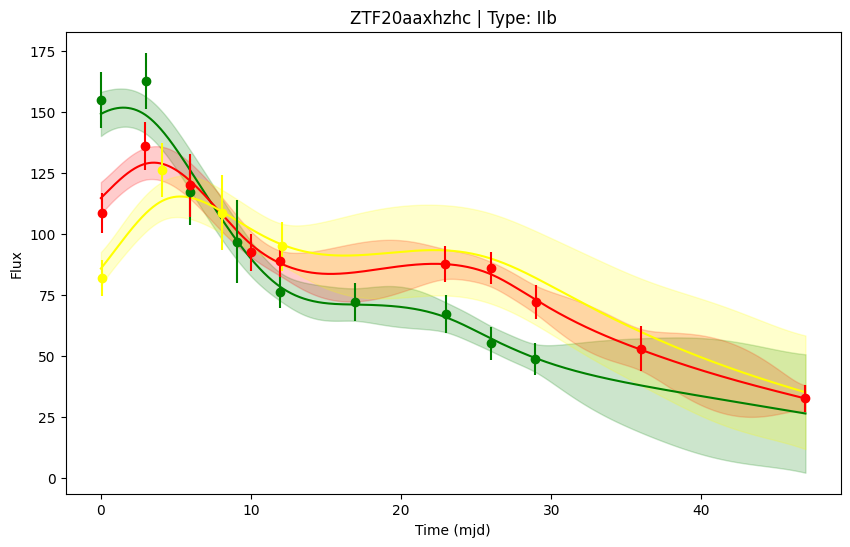

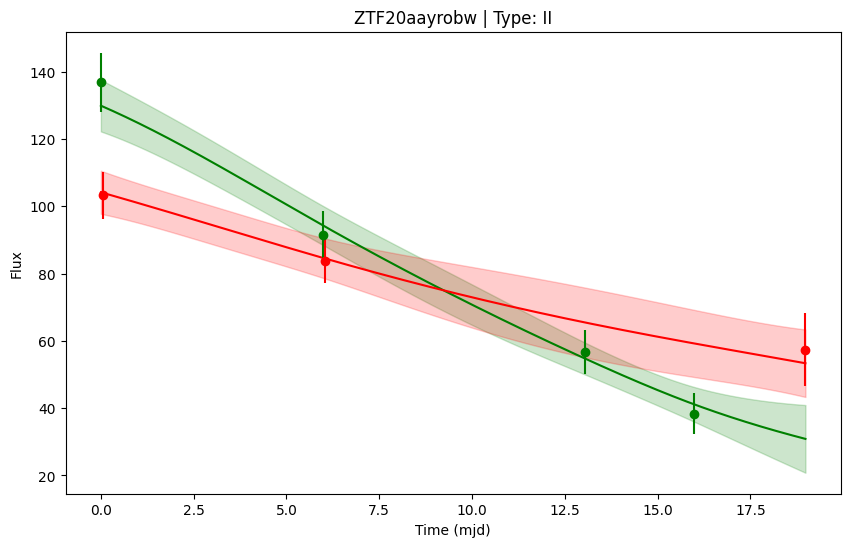

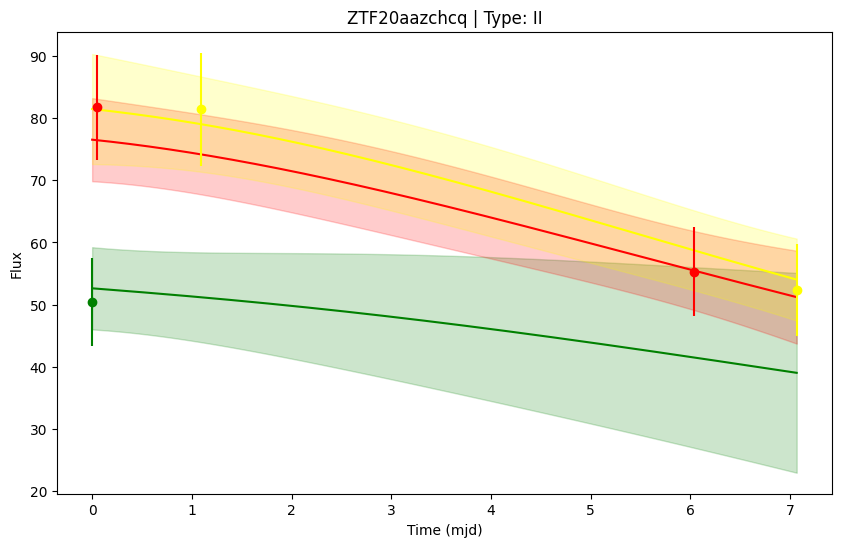

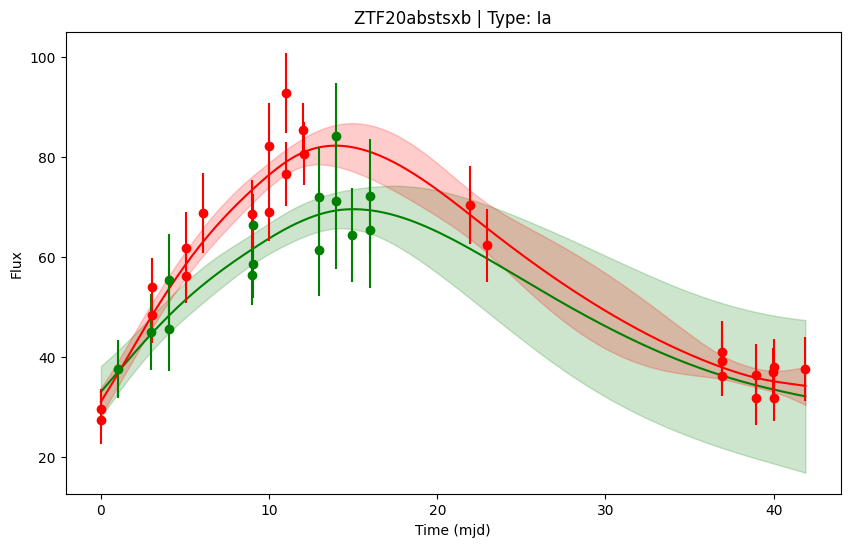

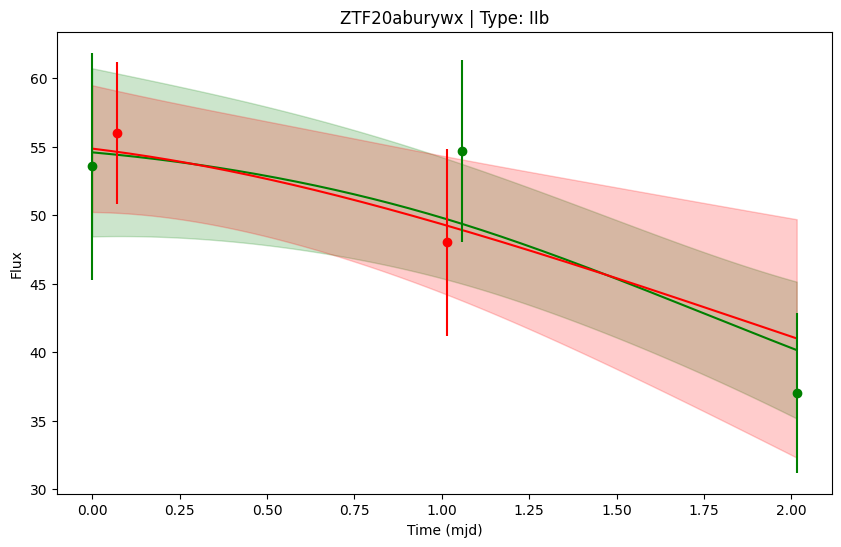

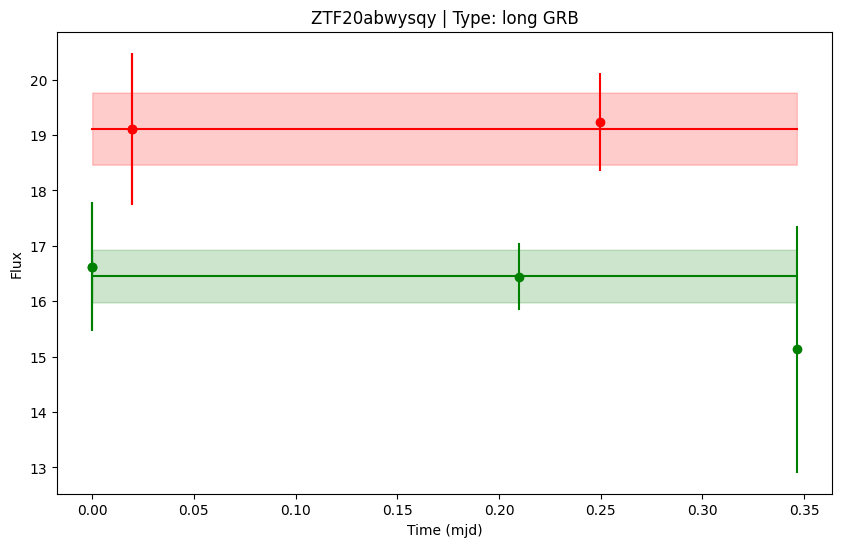

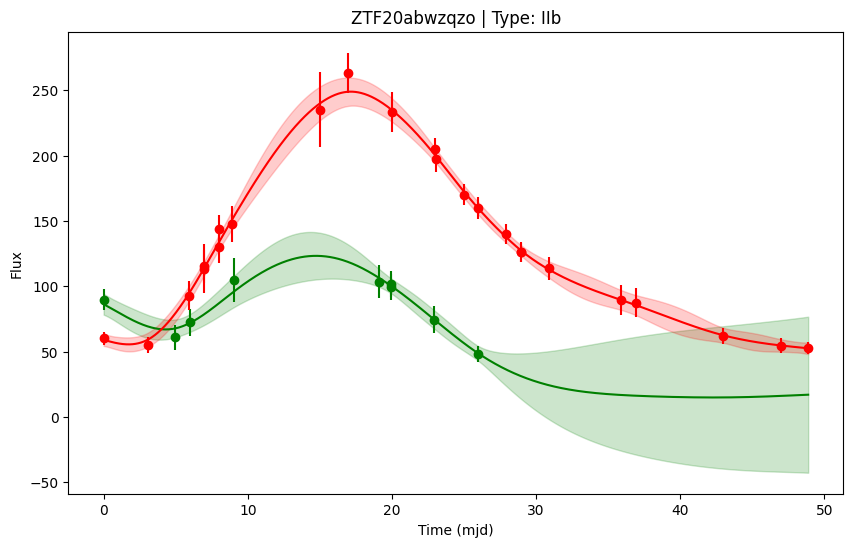

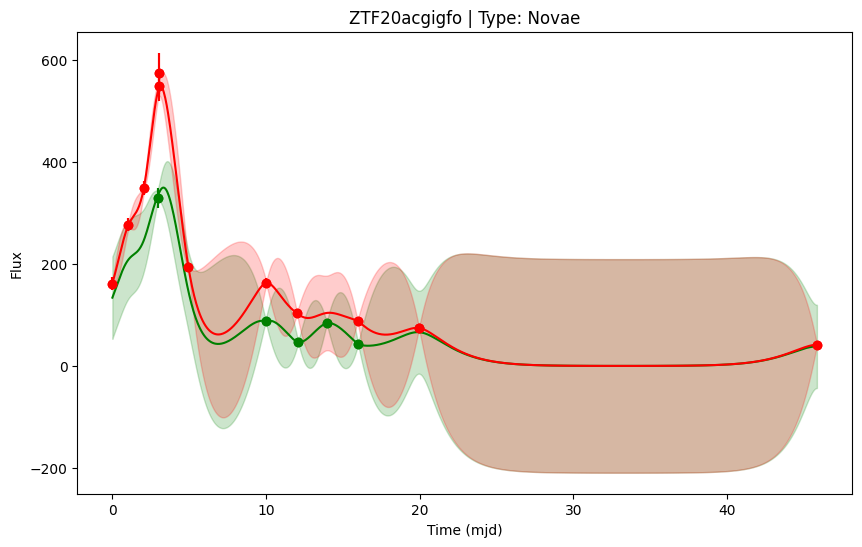

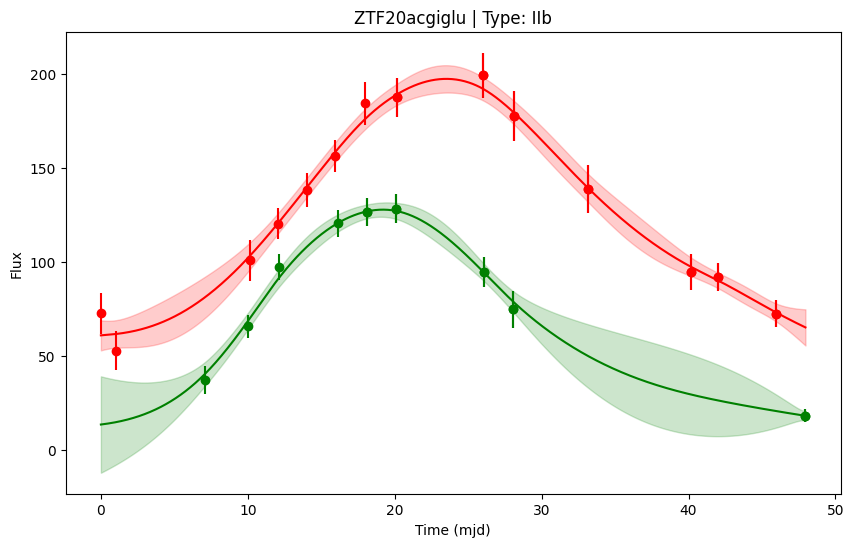

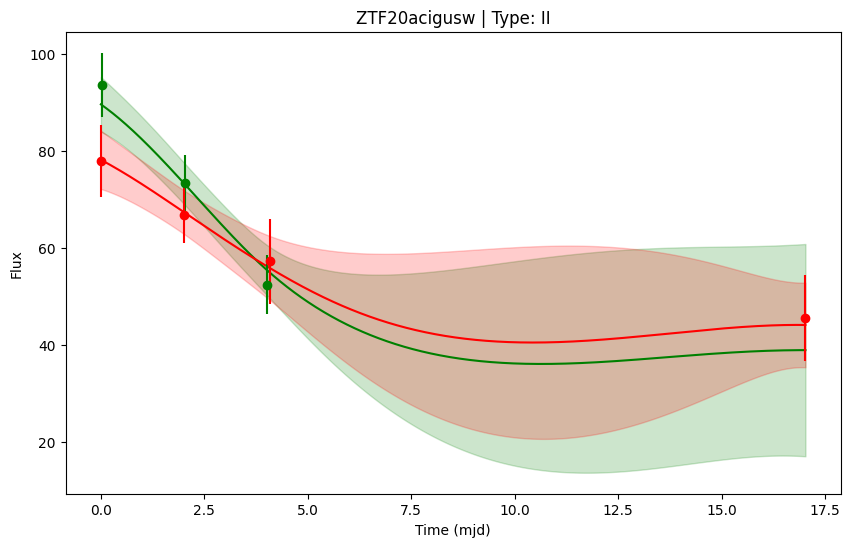

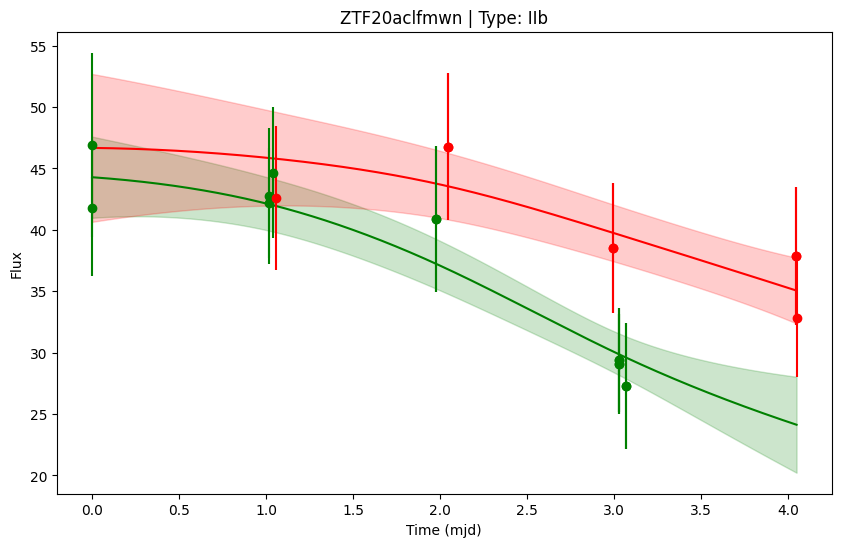

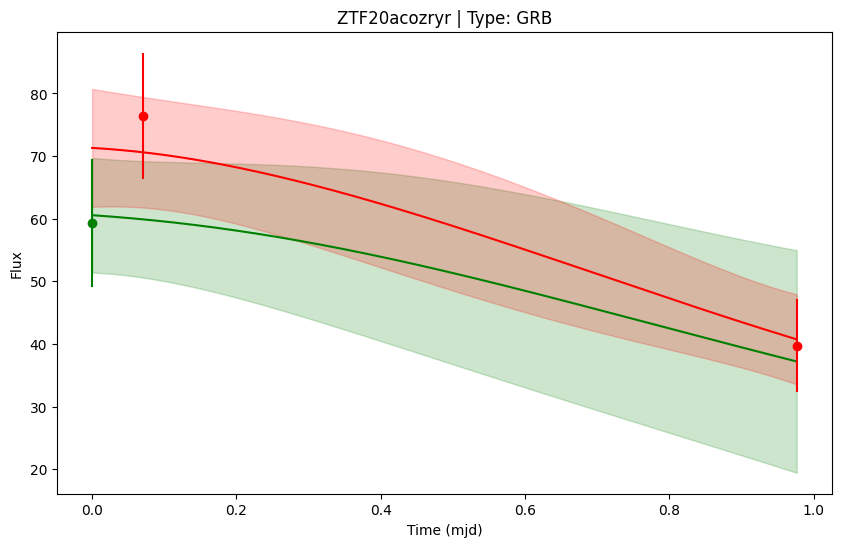

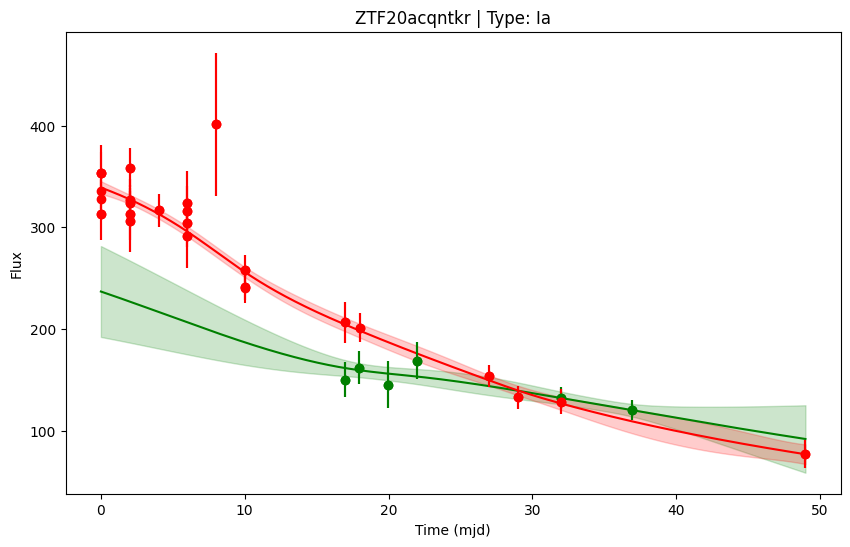

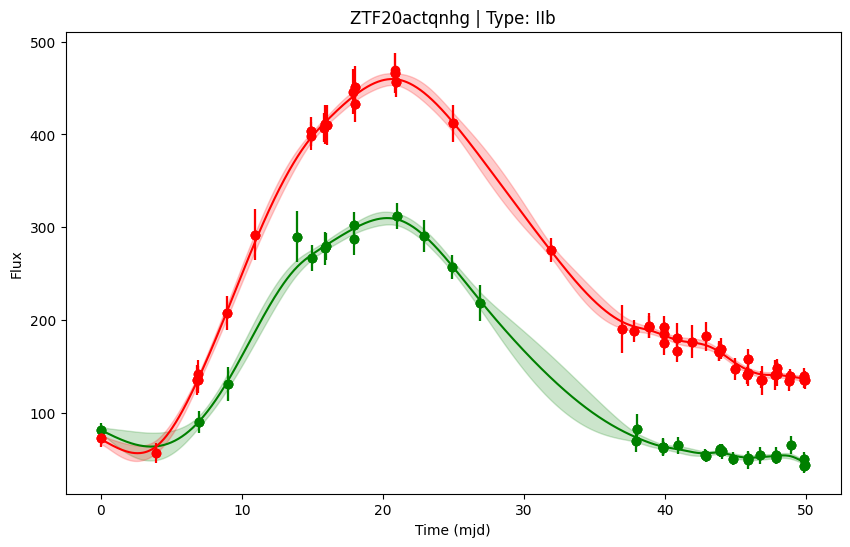

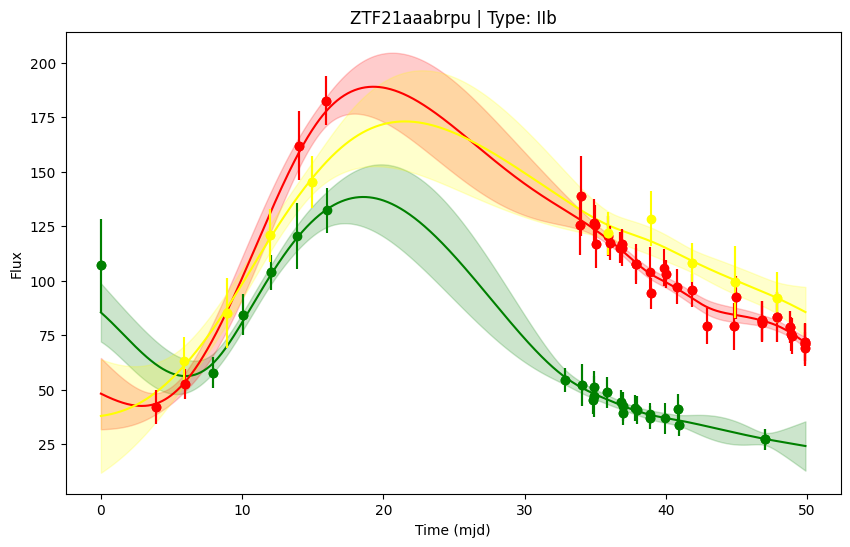

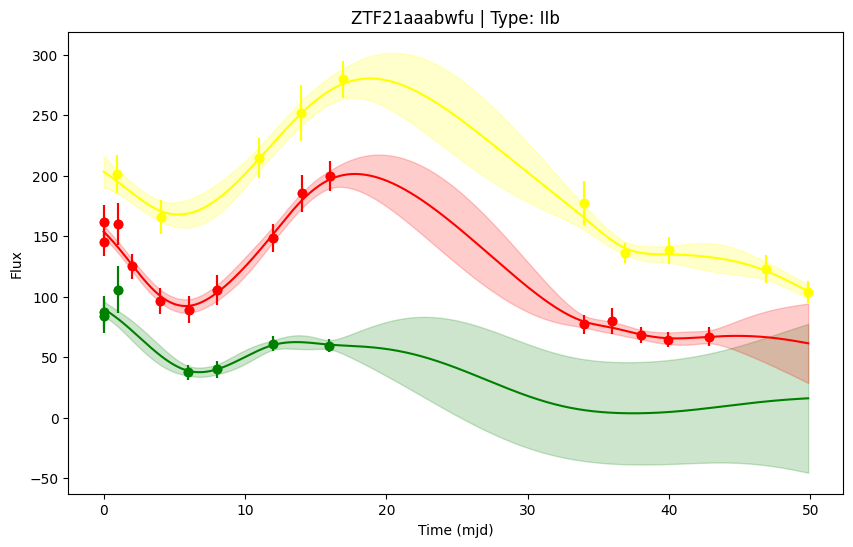

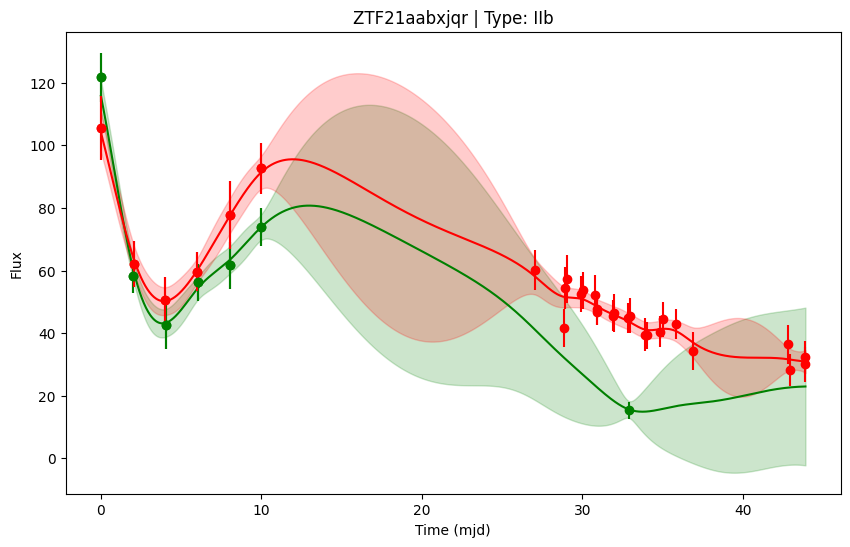

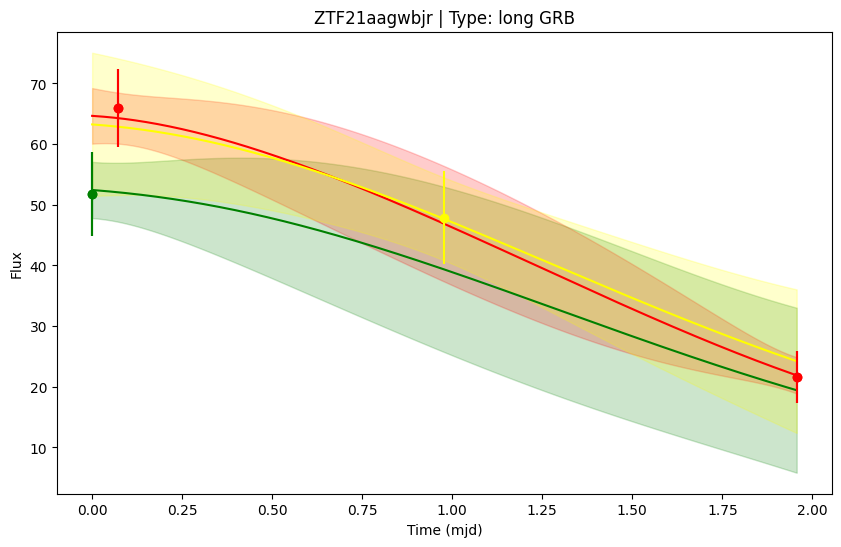

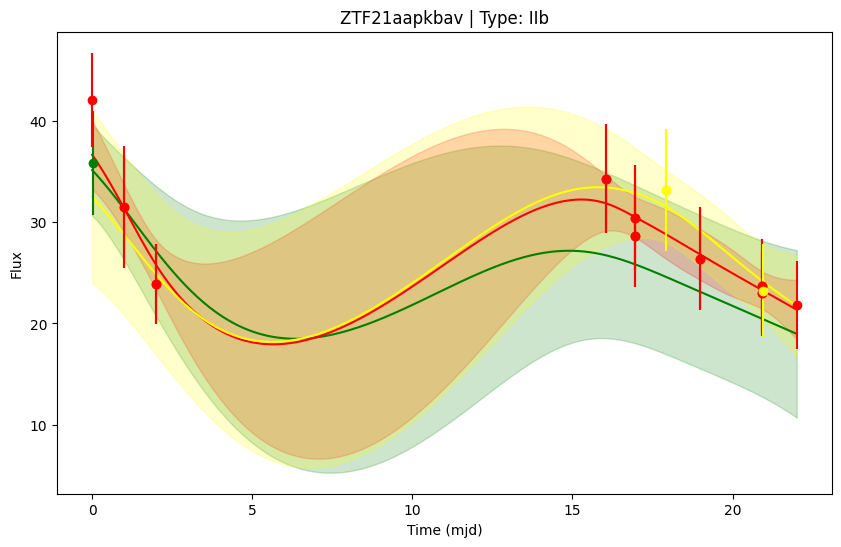

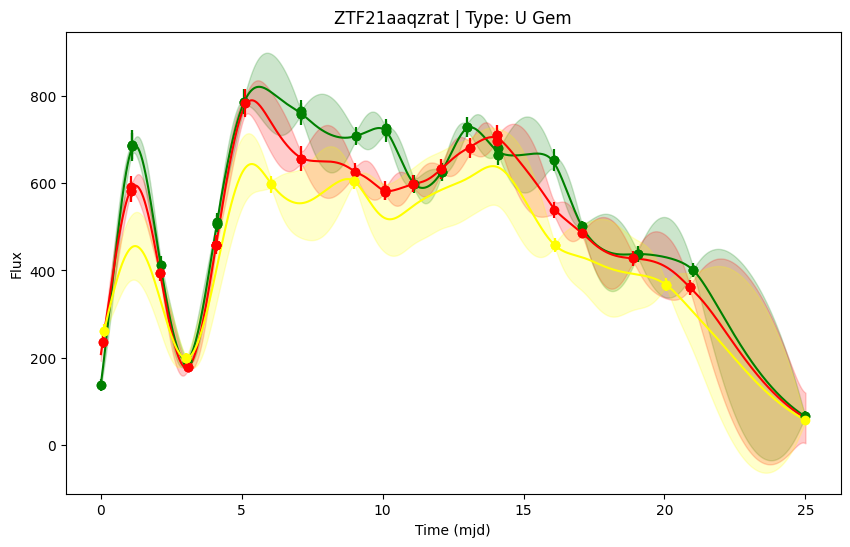

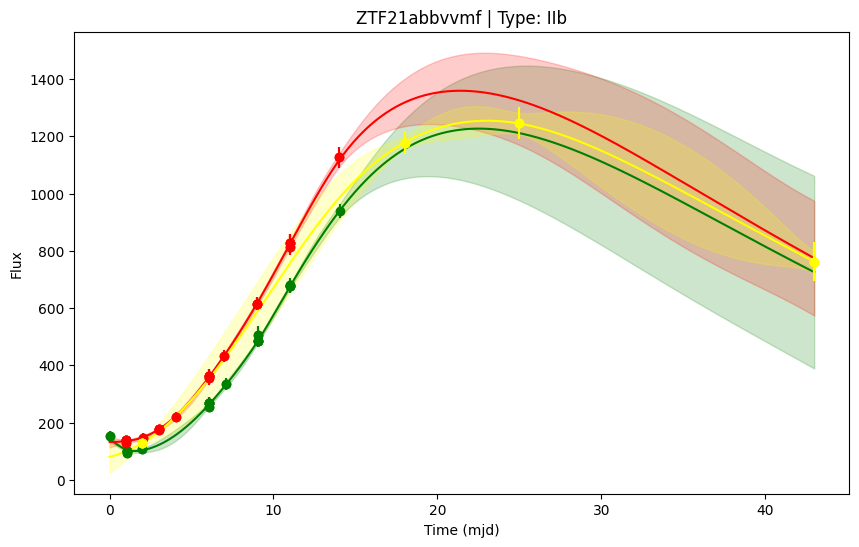

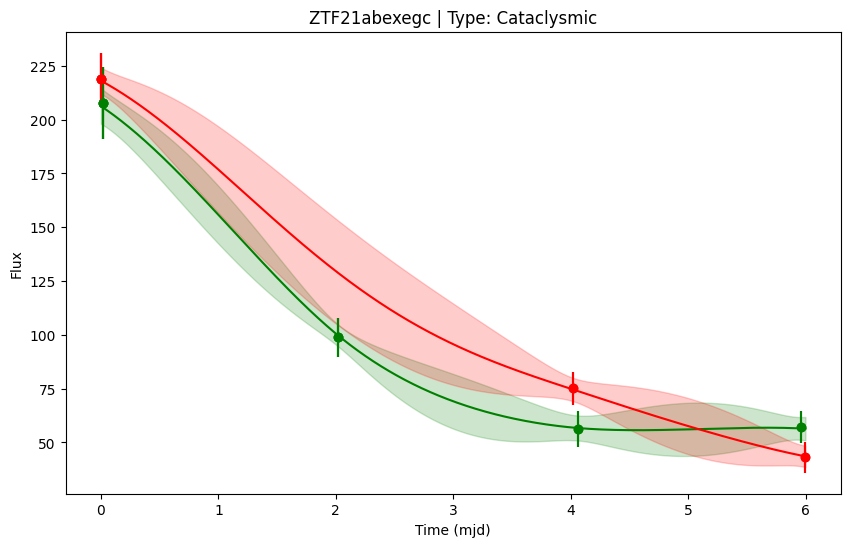

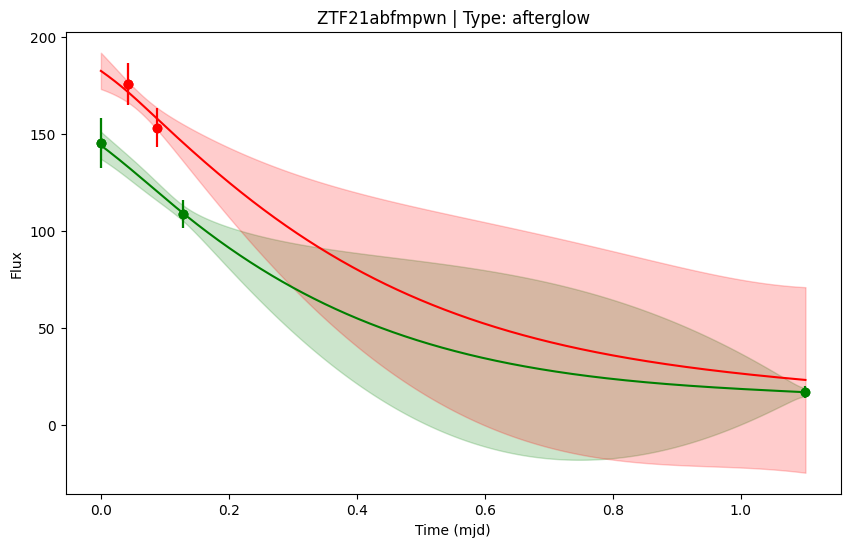

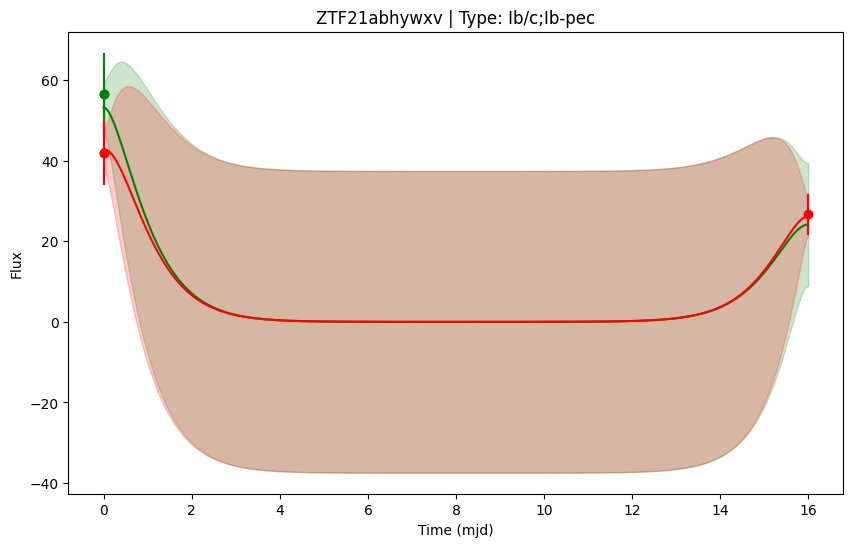

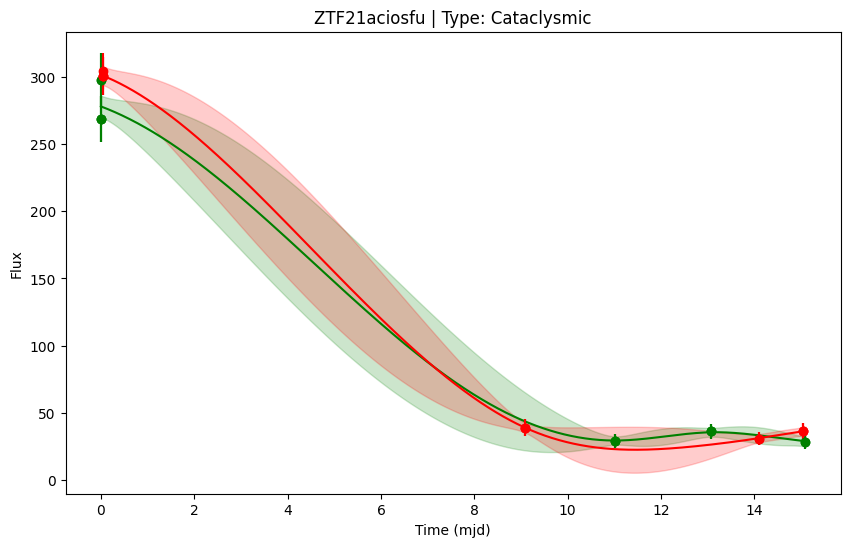

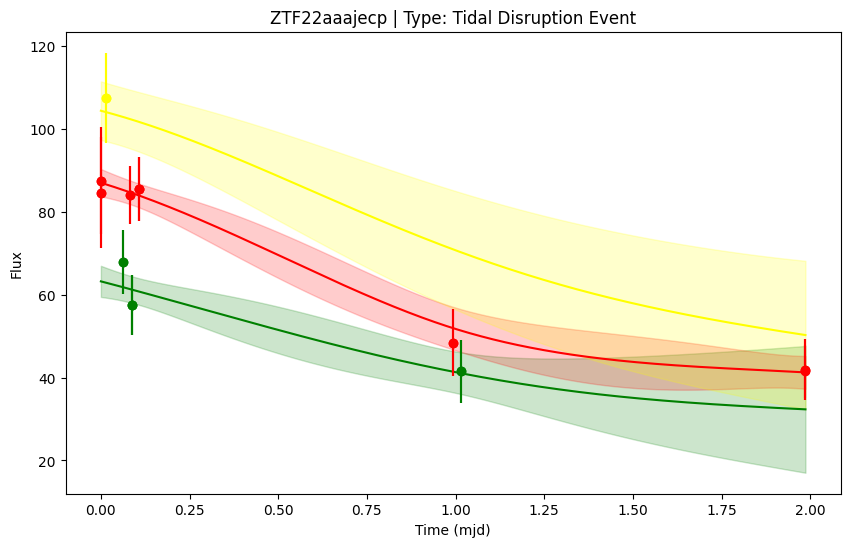

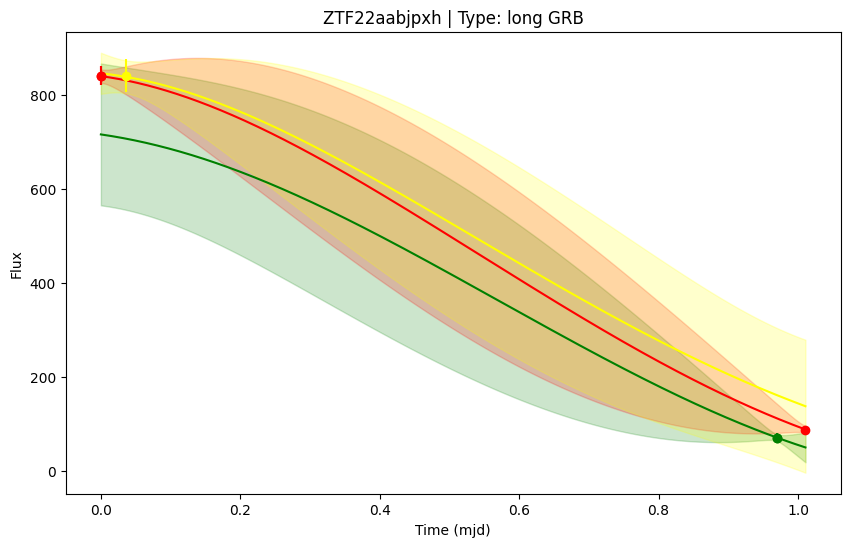

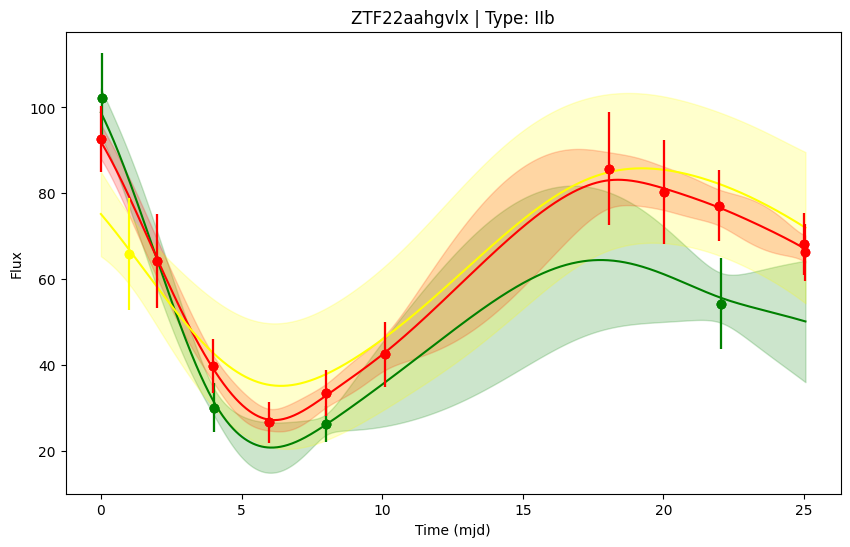

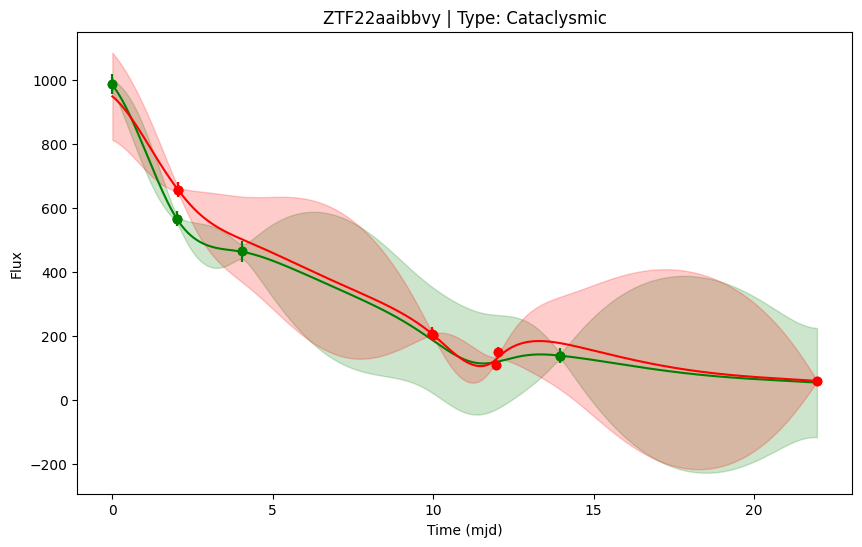

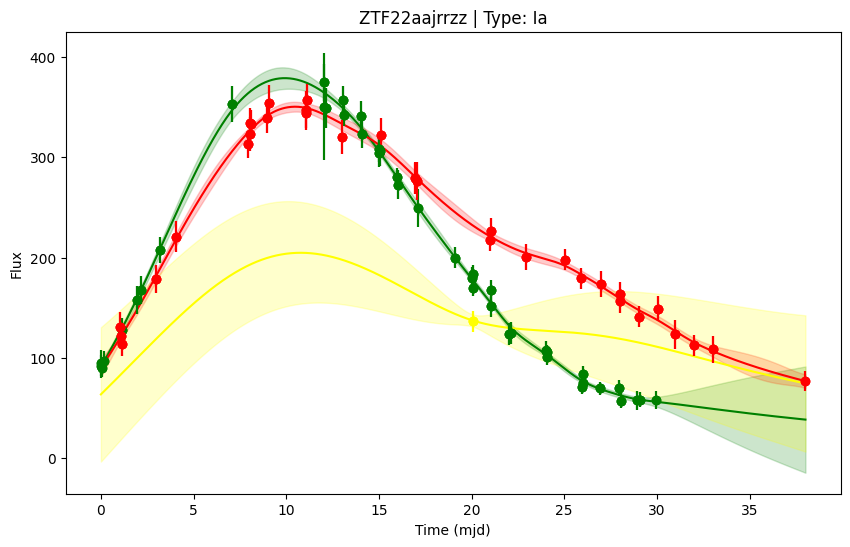

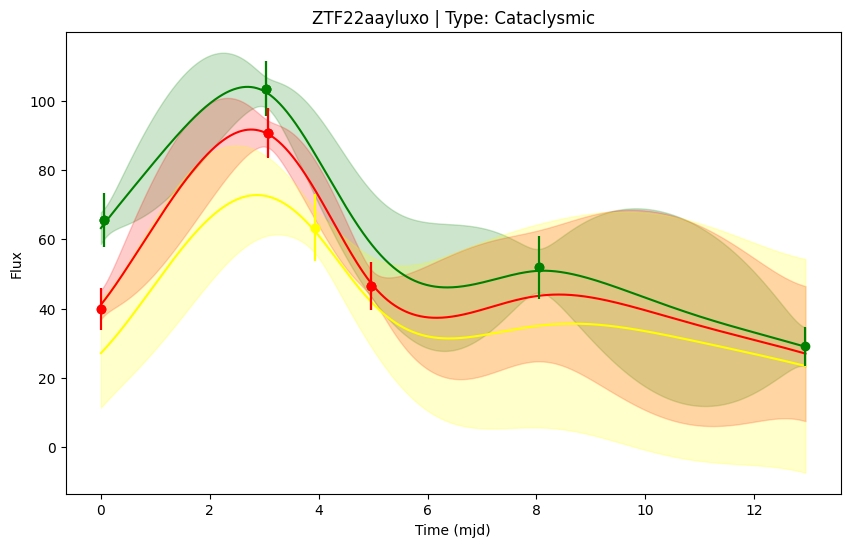

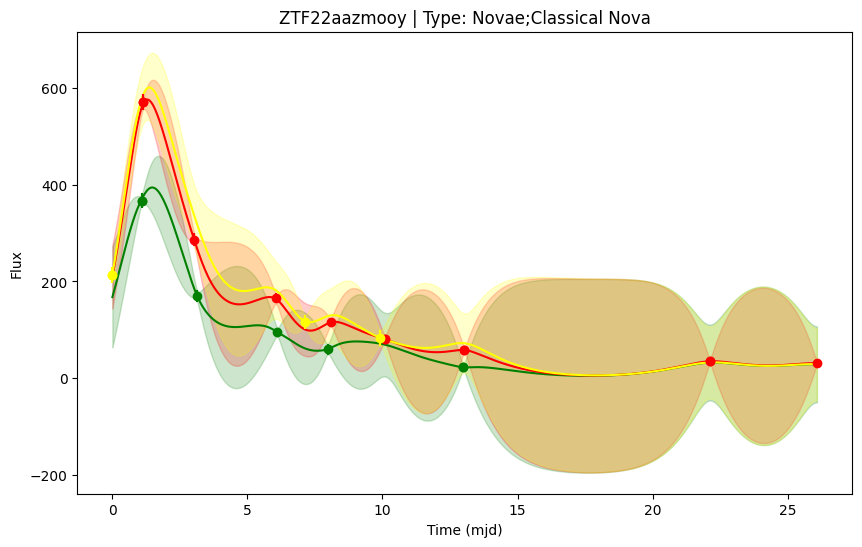

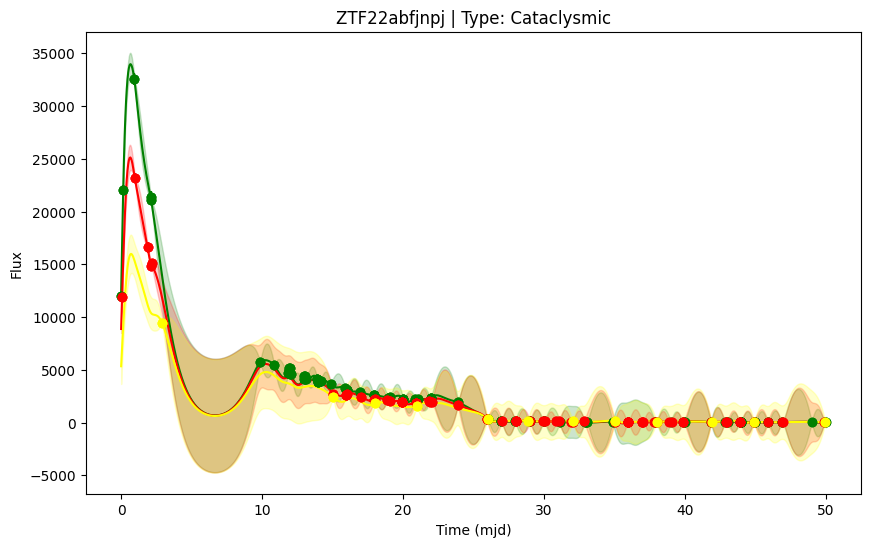

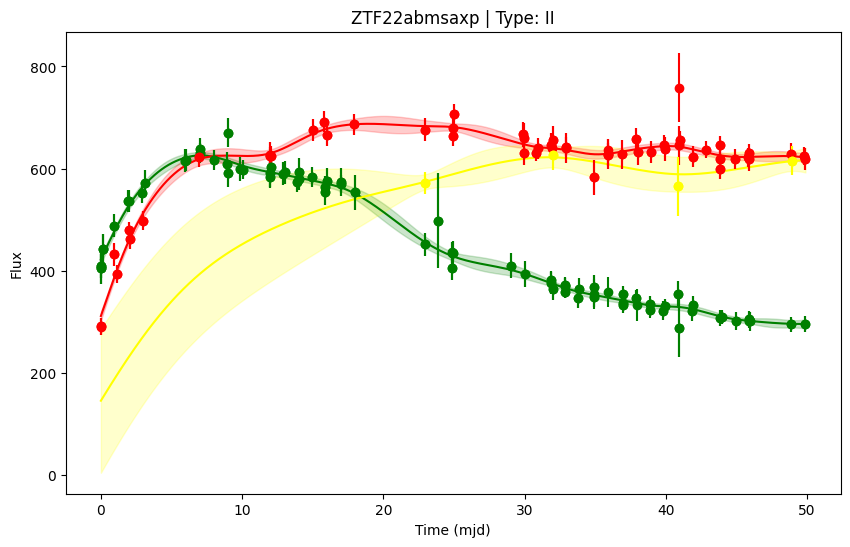

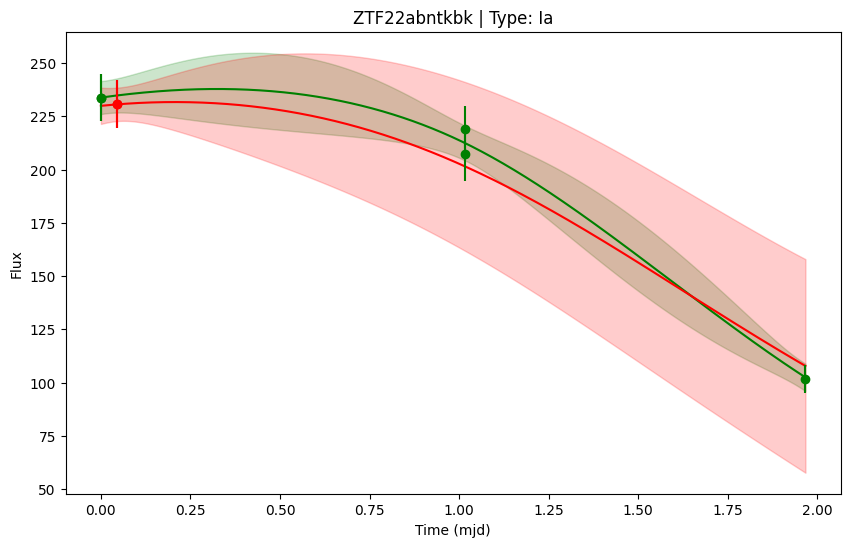

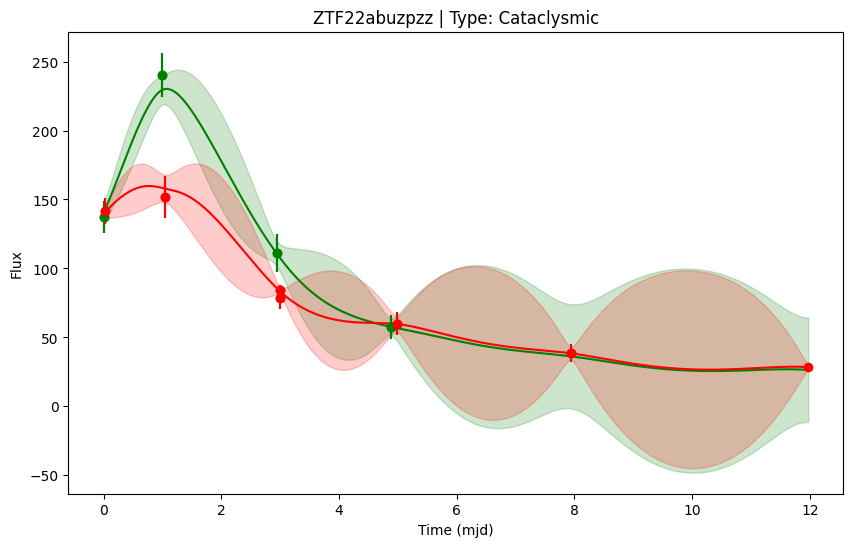

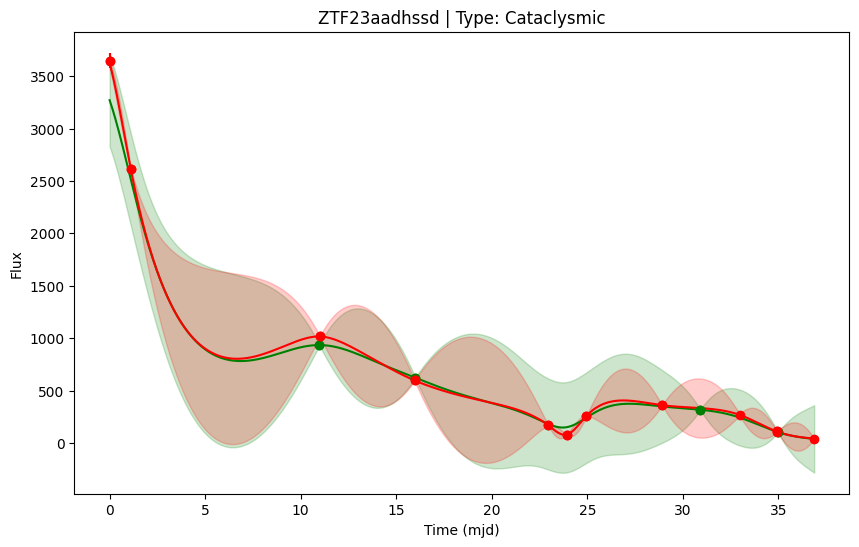

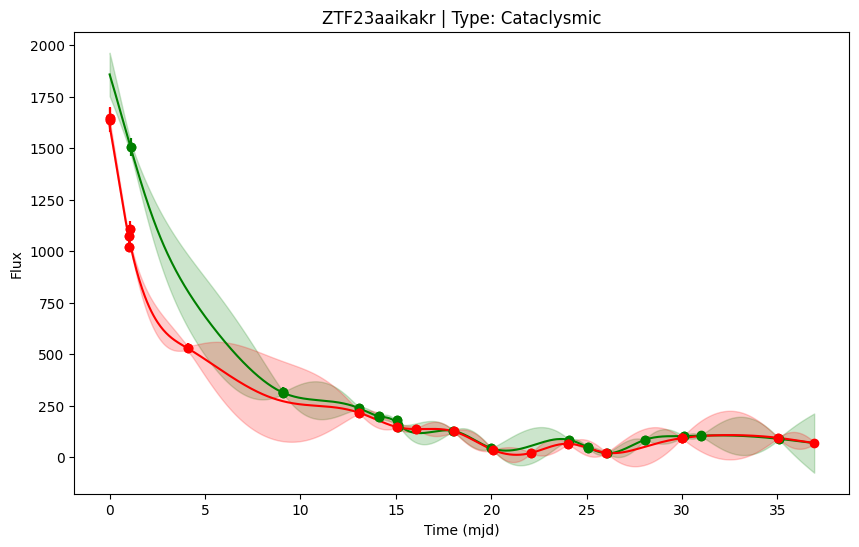

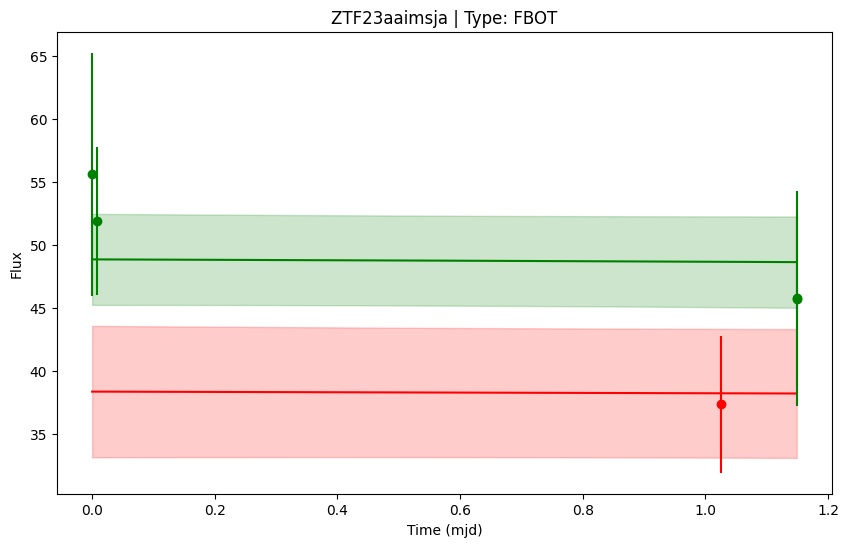

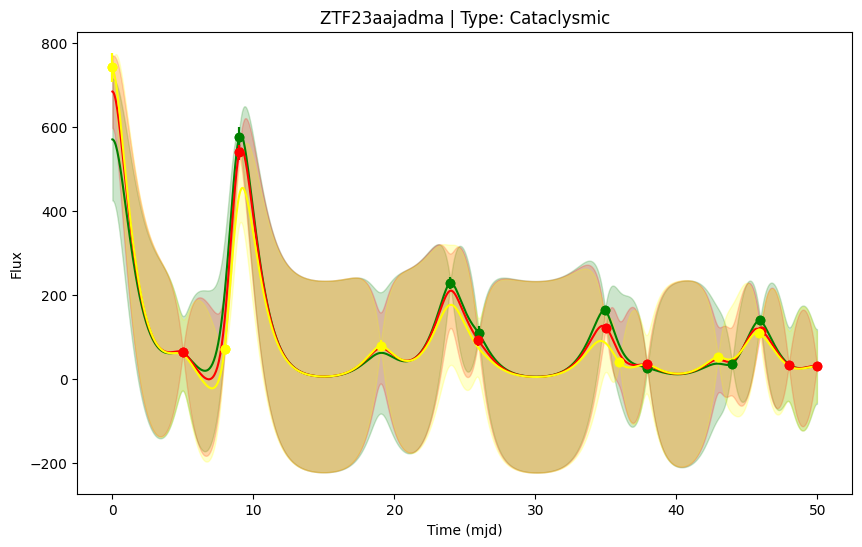

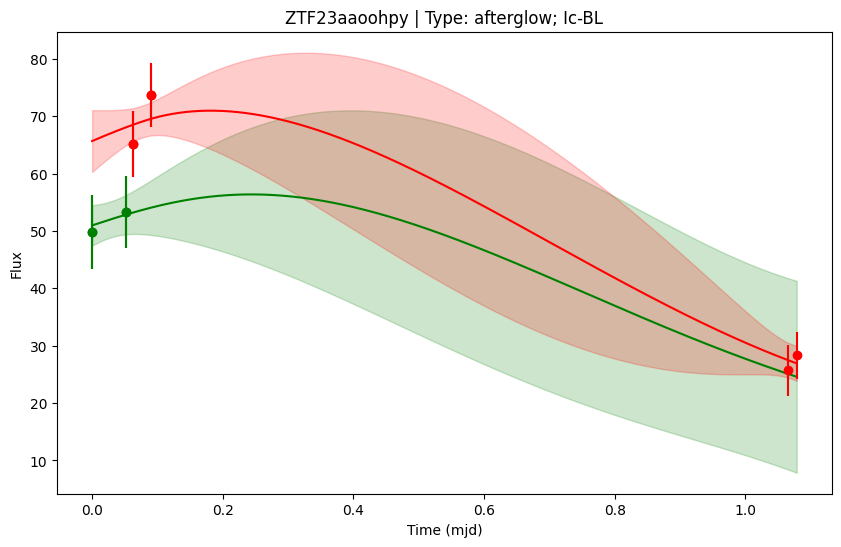

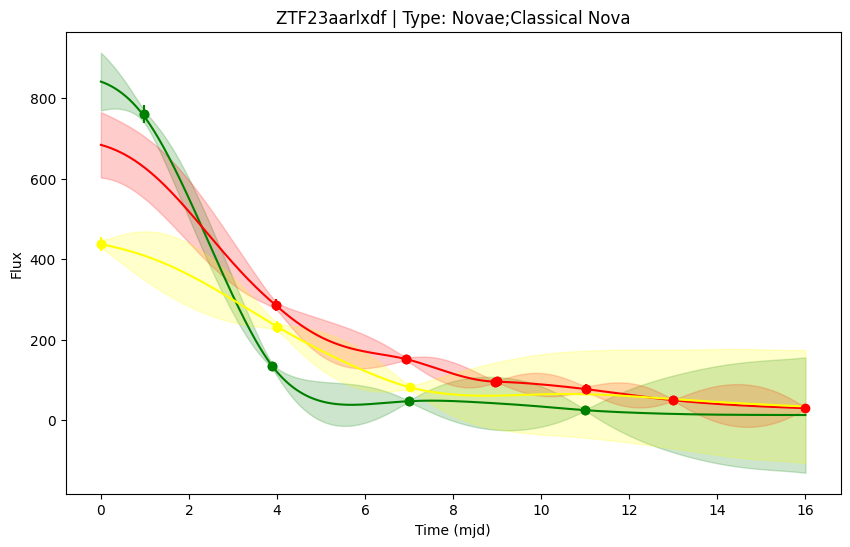

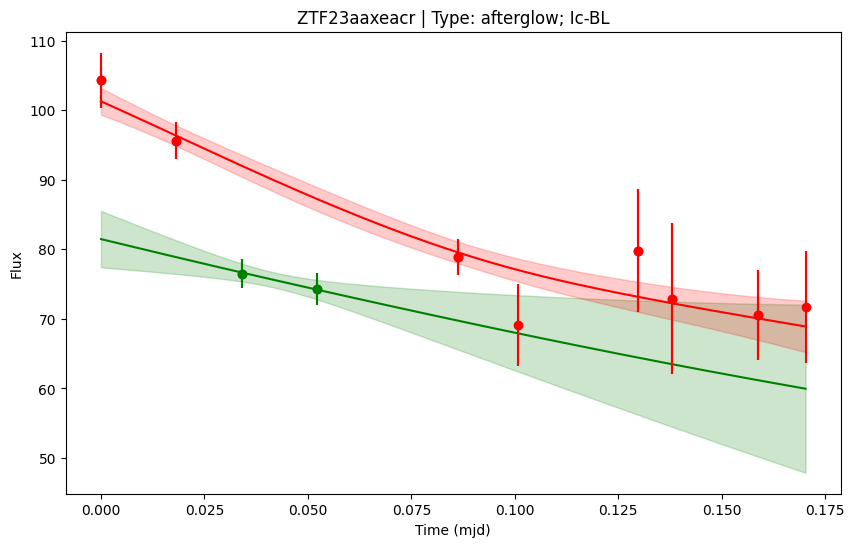

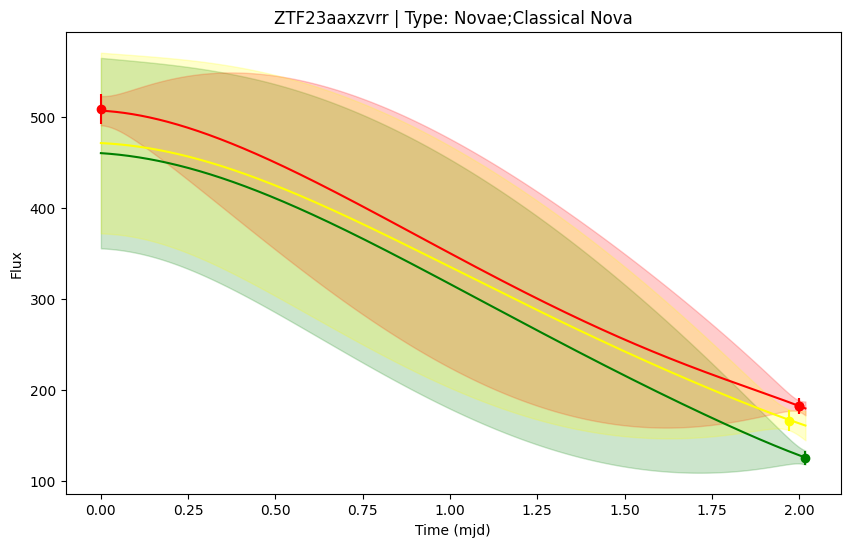

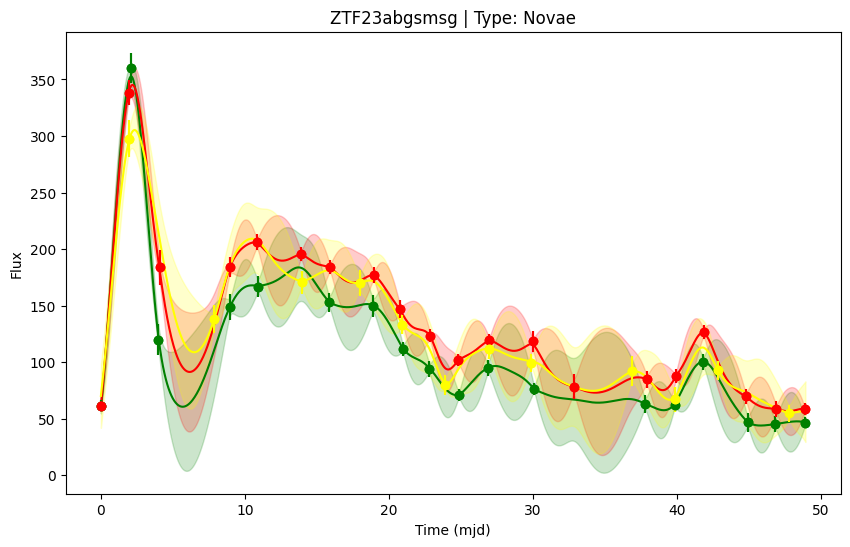

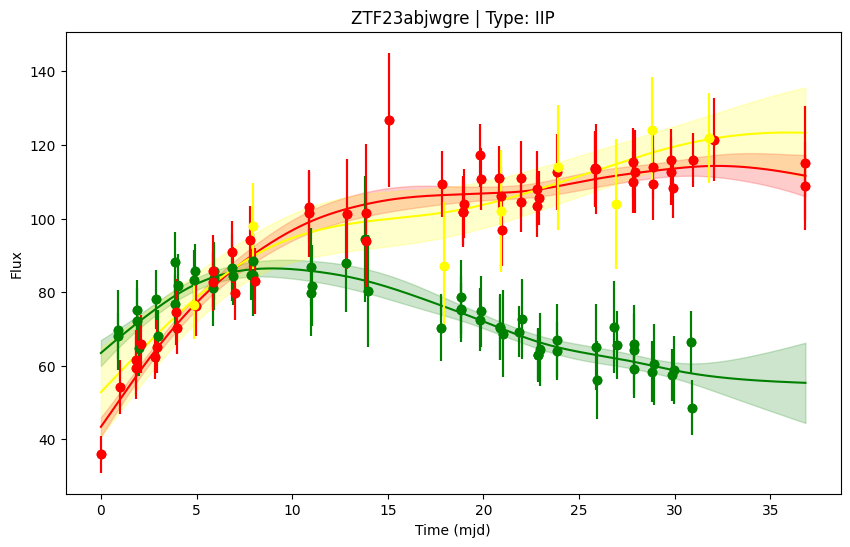

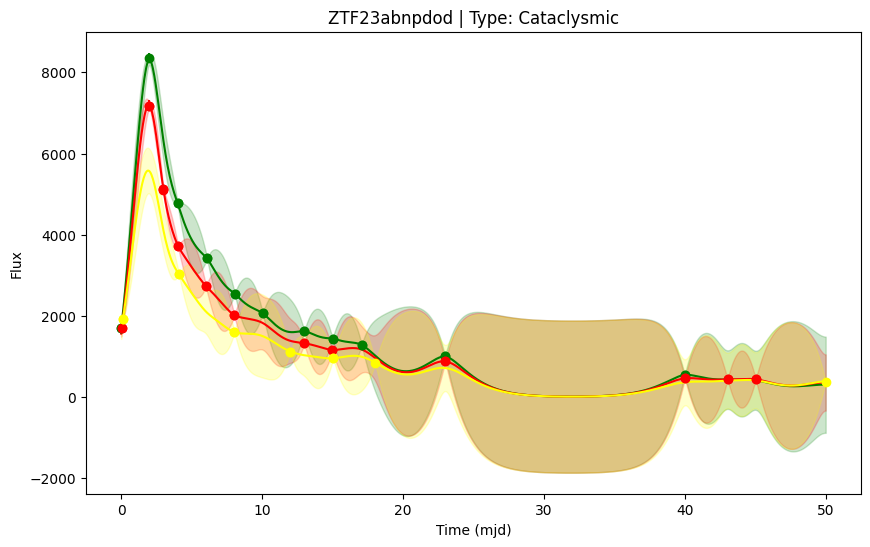

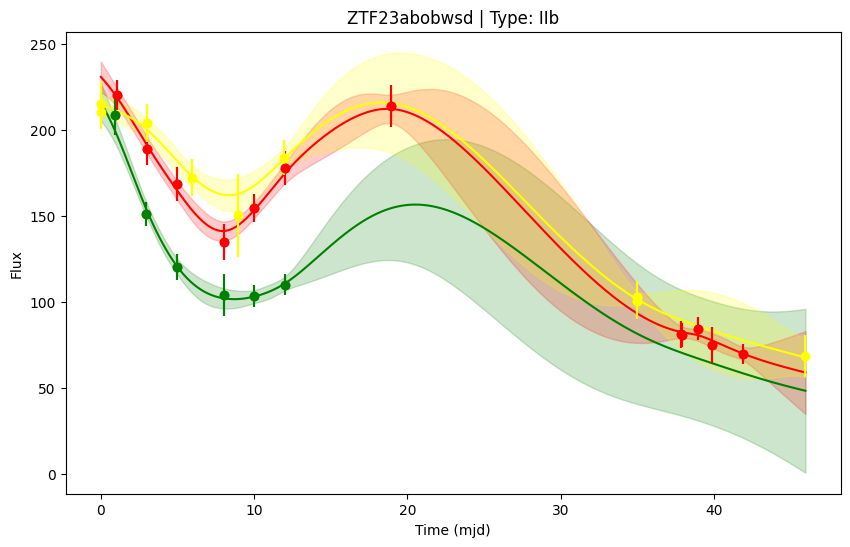

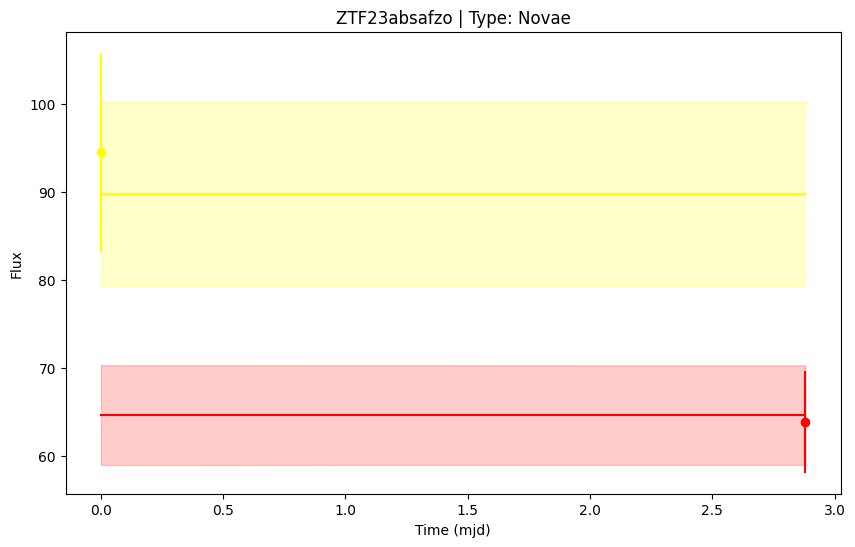

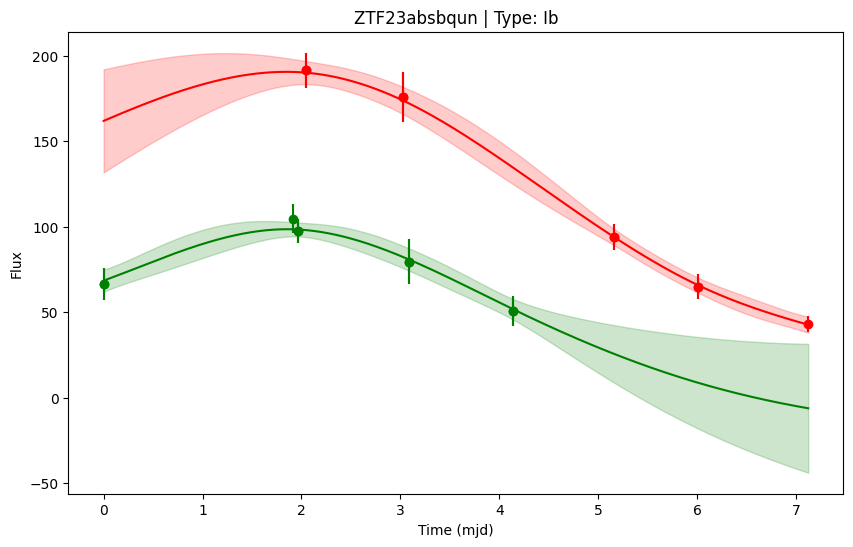

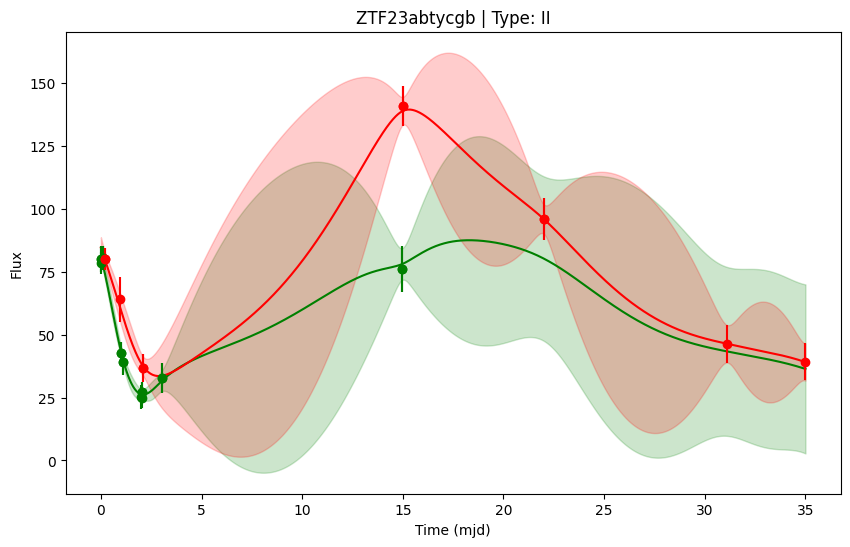

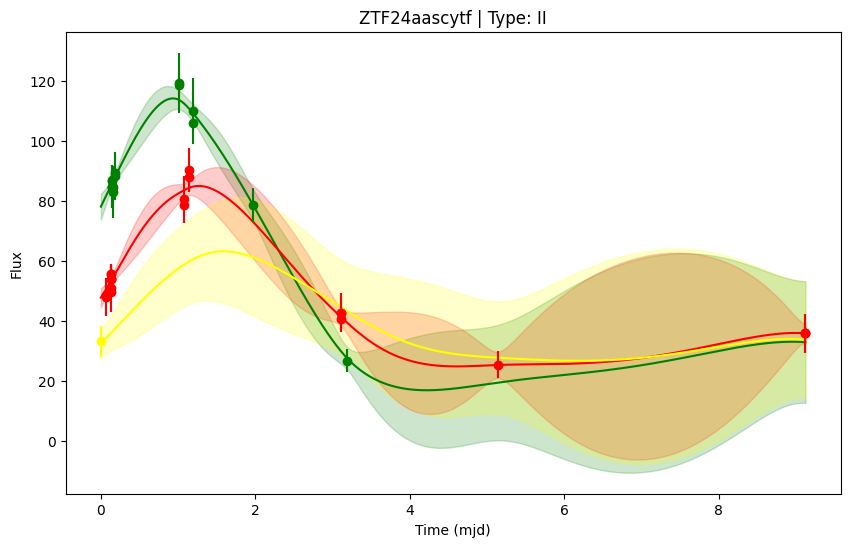

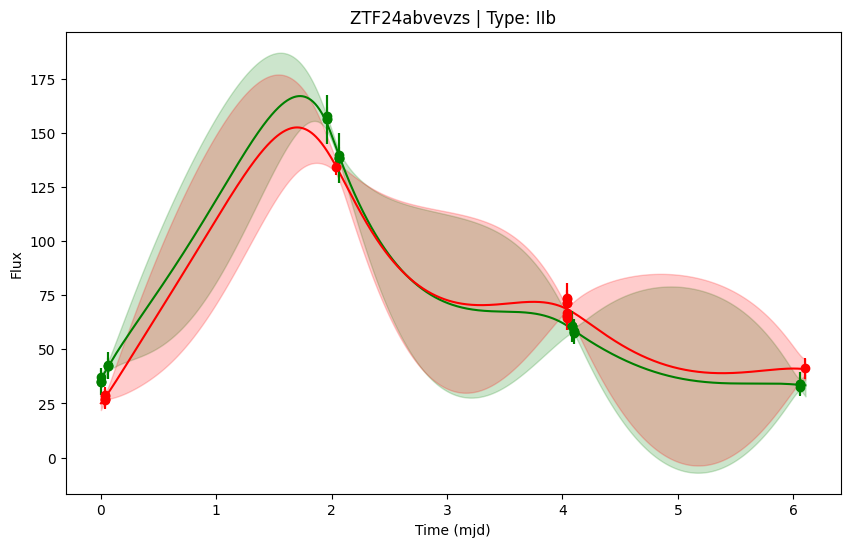

In [55]:
plot_results = total_results
obj_ids = plot_results['obj_id'].unique()
broken_obj_ids = []
for obj in obj_ids:
    one_df = plot_results[plot_results['obj_id'] == obj]
    two_df = norm_df[norm_df['obj_id']==obj]
    two_df = two_df[two_df['mjd']<50]
    fi, axi = plot_gp(one_df, show_legend=False)
    for filter_name in ['ztfg', 'ztfr', 'ztfi']:
        axi.errorbar(two_df[two_df['filter']==filter_name]['mjd'], two_df[two_df['filter']==filter_name]['flux'], yerr=two_df[two_df['filter']==filter_name]['flux_error'], fmt='o', label=f'Observed {filter_name}', color=color_dict[filter_name])
    plt.savefig(f'figures/gp_plots/{obj}.pdf')
    plt.show()

In [27]:
# question_objects = ['ZTF19abacxod', 'ZTF19abxjrge', 'ZTF21aaabrpu', 'ZTF21aaabwfu', 'ZTF21aabxjqr', 'ZTF21aapkbav', 'ZTF21aaqzrat', 'ZTF23aajadma', 'ZTF23abtycgb']
# for obj in question_objects:
#     one_df = plot_results[plot_results['obj_id'] == obj]
#     two_df = norm_df[norm_df['obj_id']==obj]
#     two_df = two_df[two_df['mjd']<50]
#     fi, axi = plot_gp(one_df, show_legend=False)
#     for filter_name in ['ztfg', 'ztfr', 'ztfi']:
#         axi.errorbar(two_df[two_df['filter']==filter_name]['mjd'], two_df[two_df['filter']==filter_name]['flux'], yerr=two_df[two_df['filter']==filter_name]['flux_error'], fmt='o', label=f'Observed {filter_name}', color=color_dict[filter_name])
#     plt.show()

In [36]:
from astropy.coordinates import Distance
import astropy.units as u
def absmag(m, z):
    '''
    Converts apparent magnitude to absolute magnitude.
    
    Args:
        m (float): apparent magnitude
        z (float): redshift
    '''
    #print(type(z))
    try:
        z = float(z)
    except:
        if type(z) == str:
            z = float(z.split('±')[0])
            #print('converted')
    if m is None or m is np.nan or z is None or z is np.nan:
        return np.nan
    else:
        #print(z)
        #print(type(z))
        if z==0:
            M = m
        elif z < 0:
            M = m
        else:
            try:
                d = Distance(unit=u.pc, z=float(z), allow_negative=True)
                M = m - 5 * np.log10(d/(10*u.pc)) + 5
            except:
                M = np.nan
        return M
absmag = np.vectorize(absmag)

def Norm2Mag(df):
    df_copy = df.copy()
    for filter in ['ztfg', 'ztfr', 'ztfi']:
        df_copy[f'mag_{filter}'] = 23.9 - 2.5 * np.log10(df_copy[f'flux_{filter}'])
        df_copy[f'abs_mag_{filter}'] = [absmag(m, z) for m, z in zip(df_copy[f'mag_{filter}'], df_copy['redshift'])]
        df_copy[f'mag_error_{filter}'] = 2.5 * df_copy[f'flux_error_{filter}'] / (df_copy[f'flux_{filter}'] * np.log(10))
    df_copy['t'] = df_copy['mjd']
    df_copy['mjd'] = df_copy['mjd'] + df_copy['mjd_0']
    # df_copy.reset_index(drop=True, inplace=True)
    return df_copy  

In [37]:
total_mag = Norm2Mag(total_results)
display(total_mag)


# # total_mag[total_mag['obj_id'] == 'ZTF18aakuewf']
# # total_mag[total_mag['mag_error_ztfg'] < 0]
# total_mag['mag_error_ztfg']

/home/tbarna/anaconda3/envs/nmma_env/lib/python3.10/site-packages/pandas/core/arraylike.py:402: RuntimeWarning: invalid value encountered in log10
  result = getattr(ufunc, method)(*inputs, **kwargs)
/home/tbarna/anaconda3/envs/nmma_env/lib/python3.10/site-packages/pandas/core/arraylike.py:402: RuntimeWarning: invalid value encountered in log10
  result = getattr(ufunc, method)(*inputs, **kwargs)
/home/tbarna/anaconda3/envs/nmma_env/lib/python3.10/site-packages/pandas/core/arraylike.py:402: RuntimeWarning: invalid value encountered in log10
  result = getattr(ufunc, method)(*inputs, **kwargs)


mjd   flux_ztfg   flux_ztfr  flux_error_ztfg  flux_error_ztfr  \
0      58226.340532  142.373588   98.668109        30.843697         1.246373   
1      58226.390513  145.014457  101.582057        30.013242         1.080243   
2      58226.440494  147.656847  104.490322        29.187955         1.080575   
3      58226.490474  150.300692  107.379974        28.367979         1.219787   
4      58226.540455  152.945927  110.245034        27.553467         1.433721   
...             ...         ...         ...              ...              ...   
72996  60652.513689   33.493383   40.961798         3.488673         5.252959   
72997  60652.519801   33.463261   40.930338         3.842217         5.054402   
72998  60652.525913   33.432509   40.895906         4.235472         4.909244   
72999  60652.532025   33.401076   40.858402         4.657035         4.823773   
73000  60652.538137   33.368917   40.817727         5.098662         4.802653   

      type        obj_id         mjd_0  redshift  flux_ztfi  ...   mag_ztfg  \
0      Ibn  ZTF18aakuewf  58226.340532    0.0636        NaN  ...  18.516426   
1      Ibn  ZTF18aakuewf  58226.340532    0.0636        NaN  ...  18.496472   
2      Ibn  ZTF18aakuewf  58226.340532    0.0636        NaN  ...  18.476866   
3      Ibn  ZTF18aakuewf  58226.340532    0.0636        NaN  ...  18.457598   
4      Ibn  ZTF18aakuewf  58226.340532    0.0636        NaN  ...  18.438655   
...    ...           ...           ...       ...        ...  ...        ...   
72996  IIb  ZTF24abvevzs  60646.432303    0.0350        NaN  ...  20.087602   
72997  IIb  ZTF24abvevzs  60646.432303    0.0350        NaN  ...  20.088579   
72998  IIb  ZTF24abvevzs  60646.432303    0.0350        NaN  ...  20.089578   
72999  IIb  ZTF24abvevzs  60646.432303    0.0350        NaN  ...  20.090599   
73000  IIb  ZTF24abvevzs  60646.432303    0.0350        NaN  ...  20.091645   

              abs_mag_ztfg mag_error_ztfg   mag_ztfr         abs_mag_ztfr  \
0      -13.834339158572867       0.235213  18.914558  -13.436207590088383   
1      -13.854293836575263       0.224712  18.882957  -13.467808093334309   
2      -13.873899560852813       0.214622  18.852310   -13.49845574640198   
3       -13.89316803455706       0.204923  18.822692   -13.52807381388012   
4       -13.91211036898427       0.195597  18.794102  -13.556663168736463   
...                    ...            ...        ...                  ...   
72996  -10.921953107792355       0.113090  19.869052  -11.140503089500001   
72997  -10.920976222847361       0.124663  19.869887  -11.139668900136918   
72998  -10.919977981452199       0.137549  19.870800  -11.138755145903318   
72999   -10.91895672288188       0.151382  19.871797  -11.137759012320572   
73000  -10.917910857423621       0.165897  19.872878  -11.136677600084674   

      mag_error_ztfr  mag_ztfi  abs_mag_ztfi mag_error_ztfi         t  
0           0.013715       NaN           nan            NaN  0.000000  
1           0.011546       NaN           nan            NaN  0.049981  
2           0.011228       NaN           nan            NaN  0.099961  
3           0.012333       NaN           nan            NaN  0.149942  
4           0.014120       NaN           nan            NaN  0.199923  
...              ...       ...           ...            ...       ...  
72996       0.139235       NaN           nan            NaN  6.081386  
72997       0.134075       NaN           nan            NaN  6.087498  
72998       0.130334       NaN           nan            NaN  6.093610  
72999       0.128183       NaN           nan            NaN  6.099721  
73000       0.127749       NaN           nan            NaN  6.105833  

[73001 rows x 21 columns]

In [ ]:
# total_mag.to_csv('gp_objects.csv', index=False)